# Import libs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

Try standard scaler too

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
house_df = pd.read_csv("train.csv")
house_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Functions

In [4]:
def get_top_1o_features(X_train, lr_model, best_ridge_model, best_lasso_model):

    betas = pd.DataFrame(index=X_train.columns)
    betas.rows = X_train.columns

    betas["LR"] = lr_model.coef_.reshape(-1)
    betas['Ridge'] = best_ridge_model.coef_.reshape(-1)
    betas['Lasso'] = best_lasso_model.coef_.reshape(-1)

    top_10_lr = np.abs(betas['LR']).sort_values(ascending=False)[:10].index
    top_10_lr_coeff = betas.loc[top_10_lr, "LR"].values

    top_10_ridge = np.abs(betas['Ridge']).sort_values(ascending=False)[:10].index
    top_10_ridge_coeff = betas.loc[top_10_ridge, "Ridge"].values

    top_10_lasso = np.abs(betas['Lasso']).sort_values(ascending=False)[:10].index
    top_10_lasso_coeff = betas.loc[top_10_lasso, "Lasso"].values

    top_10 = pd.DataFrame([top_10_lr, top_10_lr_coeff, top_10_ridge, top_10_ridge_coeff, top_10_lasso, top_10_lasso_coeff]).T
    top_10.columns = ["LR", "LR_coeff", "Ridge", "Ridge_coeff", "Lasso", "Lasso_coeff"]

    return top_10

In [5]:
def residual_analysis(errors, y_test):

    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)
    sns.kdeplot(errors)
    plt.title("Distribution of Residuals")

    plt.subplot(1,2,2)
    sns.scatterplot(y_test.values.reshape(-1), errors)
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.xlabel("y_pred")
    plt.ylabel("Residuals")
    plt.title("y_pred vs Residuals")
    
    plt.show()    

# Inspect and drop rows/columns

In [6]:
house_df.drop(["Id"], axis=1, inplace=True)
house_df.shape

(1460, 80)

In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Drop columns with null values > 40%

In [8]:
threshold = .4

drop_cols = house_df.columns[ (house_df.isna().sum() / house_df.shape[0]) > threshold ]
print("Dropped features:" + drop_cols)

house_df.drop(drop_cols, axis=1, inplace=True)
house_df.head()

Index(['Dropped features:Alley', 'Dropped features:FireplaceQu',
       'Dropped features:PoolQC', 'Dropped features:Fence',
       'Dropped features:MiscFeature'],
      dtype='object')


MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    AllPub    Inside       Gtl  ...             0         0           0   
1    AllPub       FR2       Gtl  ...             0         0           0   
2    AllPub    Inside       Gtl  ...             0         0           0   
3    AllPub    Corner       Gtl  ...           272         0           0   
4    AllPub       FR2       Gtl  ...             0         0           0   

  PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0        0       0       2    2008        WD         Normal    208500  
1        0       0       5    2007        WD         Normal    181500  
2        0       0       9    2008        WD         Normal    223500  
3        0       0       2    2006        WD        Abnorml    140000  
4        0       0      12    2008        WD         Normal    250000  

[5 rows x 75 columns]

Drop Rows with any null value

In [9]:
house_df.dropna(axis=0, how='any', inplace=True)
#house_df.isna().sum().sum()
house_df.shape

(1094, 75)

In [10]:
house_df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1094.000000  1094.000000    1094.000000  1094.000000  1094.000000   
mean     56.128885    70.759598   10132.346435     6.247715     5.575868   
std      41.976345    24.508859    8212.249621     1.366797     1.066500   
min      20.000000    21.000000    1300.000000     2.000000     2.000000   
25%      20.000000    60.000000    7606.750000     5.000000     5.000000   
50%      50.000000    70.000000    9444.500000     6.000000     5.000000   
75%      70.000000    80.000000   11387.250000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1094.000000   1094.000000  1094.000000  1094.000000  1094.000000  ...   
mean   1972.412249   1985.915905   109.855576   448.191956    45.252285  ...   
std      31.189752     20.930772   190.667459   468.728095   159.075003  ...   
min    1880.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1953.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1975.000000   1995.000000     0.000000   384.500000     0.000000  ...   
75%    2003.000000   2005.000000   171.750000   712.750000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1094.000000  1094.000000    1094.000000  1094.000000  1094.000000   
mean     94.341865    46.946984      22.053016     3.266910    16.498172   
std     122.624615    64.820019      61.570502    29.655973    58.455303   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    28.000000       0.000000     0.000000     0.000000   
75%     169.750000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea      MiscVal       MoSold       YrSold      SalePrice  
count  1094.000000  1094.000000  1094.000000  1094.000000    1094.000000  
mean      3.007313    23.550274     6.335466  2007.786106  187033.263254  
std      40.713175   167.135237     2.694558     1.334307   83165.332151  
min       0.000000     0.000000     1.000000  2006.000000   35311.000000  
25%       0.000000     0.000000     5.000000  2007.000000  132500.000000  
50%       0.000000     0.000000     6.000000  2008.000000  165750.000000  
75%       0.000000     0.000000     8.000000  2009.000000  221000.000000  
max     648.000000  2500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [11]:
non_num_cols = house_df.dtypes[house_df.dtypes == 'object'].index
non_num_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
num_cols = house_df.dtypes[(house_df.dtypes == "int64") | (house_df.dtypes == "float64")].index
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [13]:
house_df.isna().sum().sum()

0

# EDA

## Pair-wise

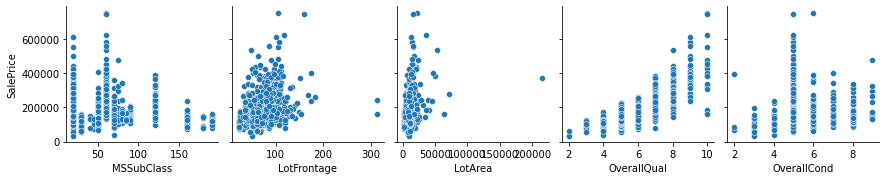

In [14]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[0:5])
plt.show()

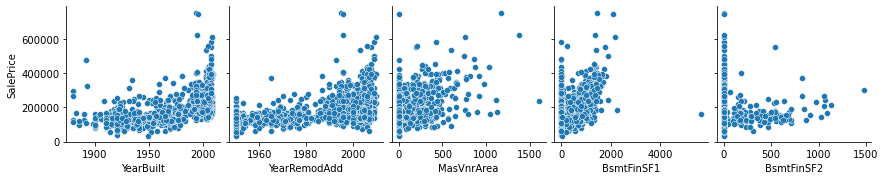

In [15]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[5:10])
plt.show()

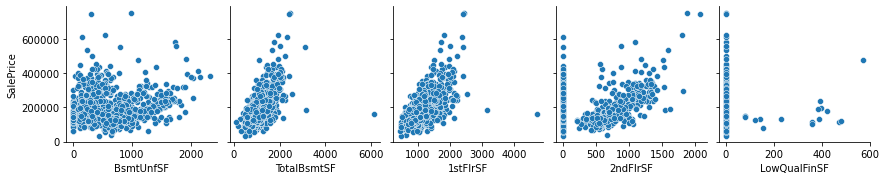

In [16]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[10:15])
plt.show()

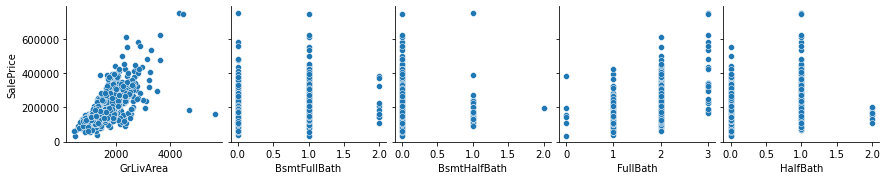

In [17]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[15:20])
plt.show()

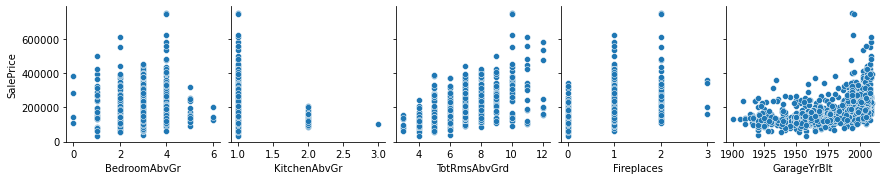

In [18]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[20:25])
plt.show()

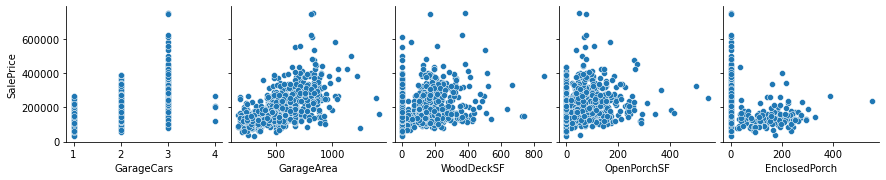

In [19]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[25:30])
plt.show()

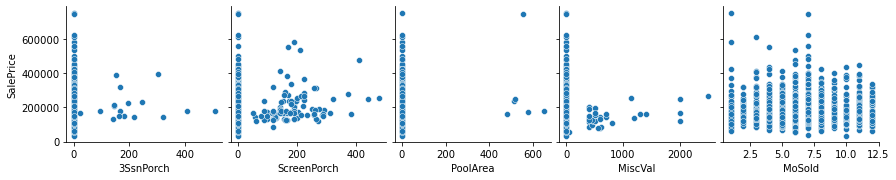

In [20]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[30:35])
plt.show()

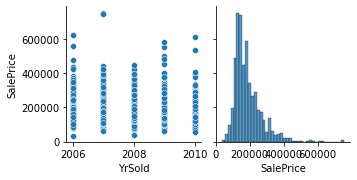

In [21]:
sns.pairplot(data=house_df, y_vars=["SalePrice"], x_vars=num_cols[35:40])
plt.show()

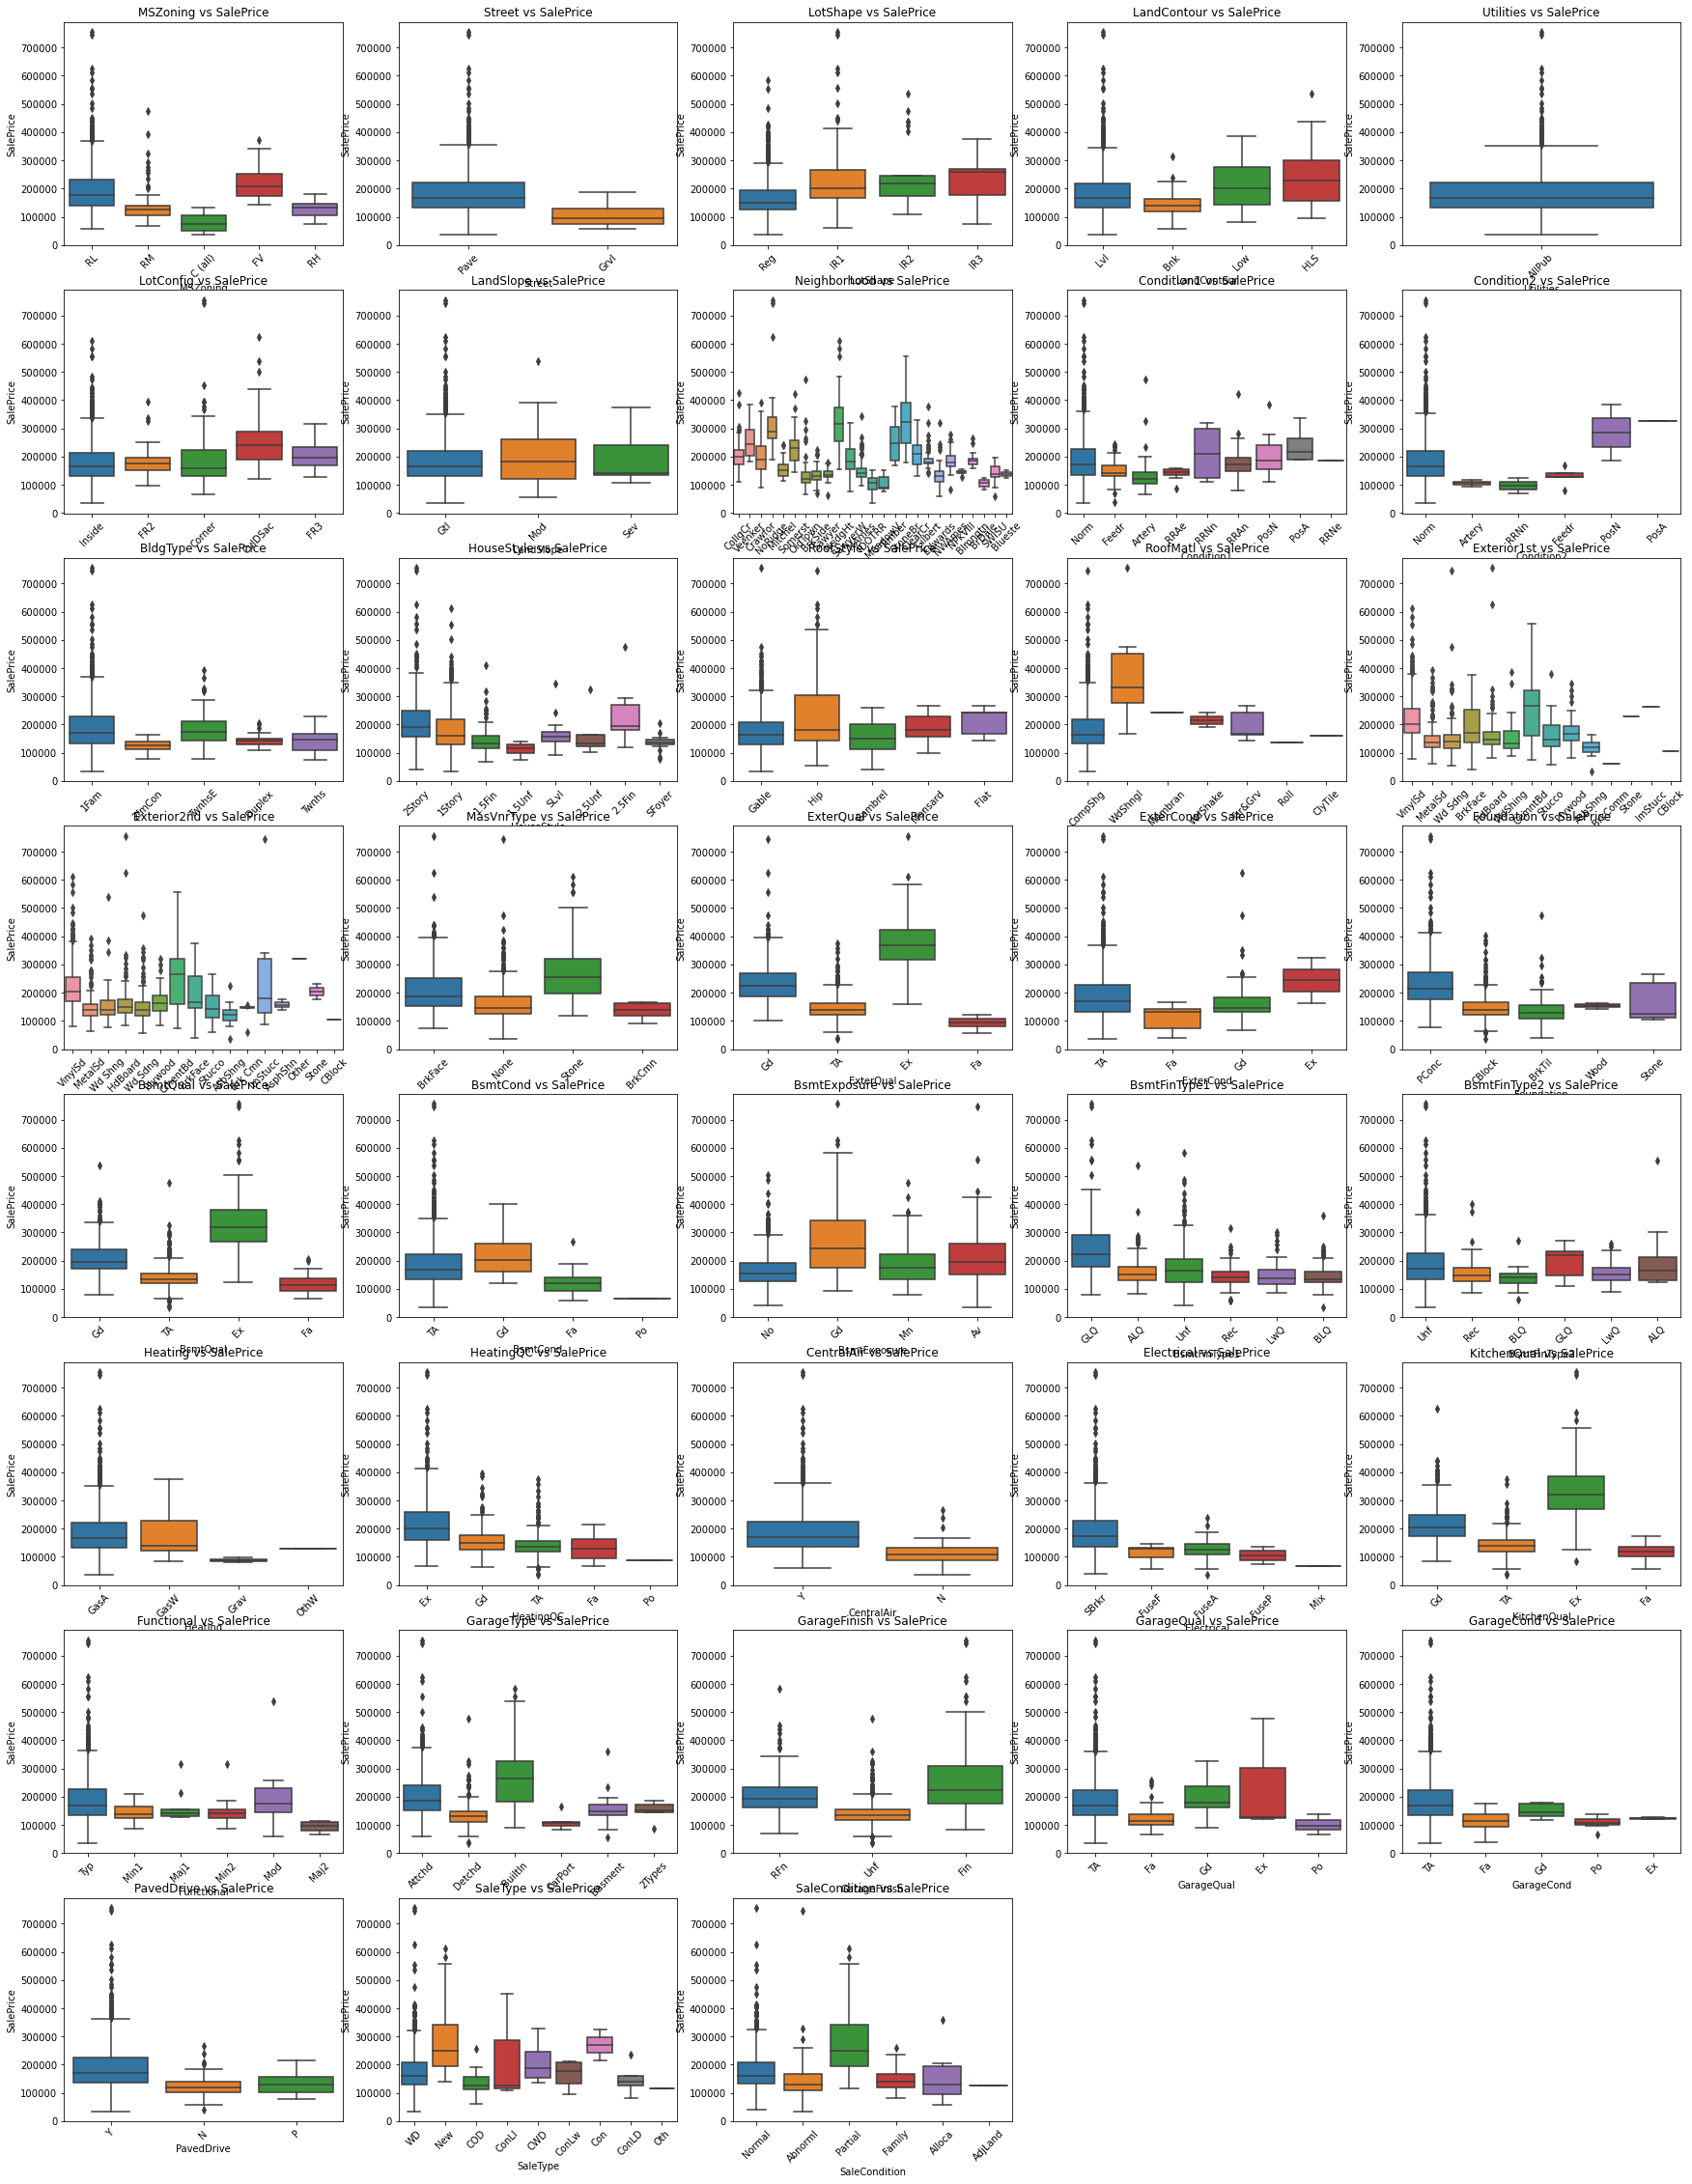

In [22]:
plt.figure(figsize=(30, 40))

for i in range(0,len(non_num_cols)):
    plt.subplot(8,5,i+1)
    sns.boxplot(x = non_num_cols[i], y = 'SalePrice', data = house_df)
    plt.xticks(rotation=45)
    plt.title(non_num_cols[i] + " vs " + "SalePrice")
plt.show()

## Transformations for Linear Relationship

In [23]:
def plot_transformations(x,y,df):

    plt.figure(figsize=(30,7))

    plt.subplot(1,5,1)
    X = df[x]
    Y = df[y]
    sns.regplot(X,Y)
    plt.title(x + " vs " + y)

    plt.subplot(1,5,2)
    X = df[x] * df[x]
    Y = df[y]
    sns.regplot(X,Y)
    plt.title("Square of " + x + " vs " + y)

    plt.subplot(1,5,3)
    X = np.log(df[x])
    Y = house_df[y]
    sns.regplot(X,Y)
    plt.title("Log of " + x + " vs " + y)

    plt.subplot(1,5,4)
    X = np.sqrt(df[x])
    Y = house_df[y]
    sns.regplot(X,Y)
    plt.title("Sqrt of " + x + " vs " + y)

    plt.subplot(1,5,5)
    X = df[x]
    Y = np.log(house_df[y])
    sns.regplot(X,Y)
    plt.title(x + " vs " + "Log of " + y)

    plt.show()

In [24]:
cat_cols = non_num_cols.tolist() + ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold" ]
len(cat_cols)

51

In [25]:
cont_cols = []
for col in num_cols:
    if col not in ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold" ]:
        cont_cols.append(col)

len(cont_cols)

24

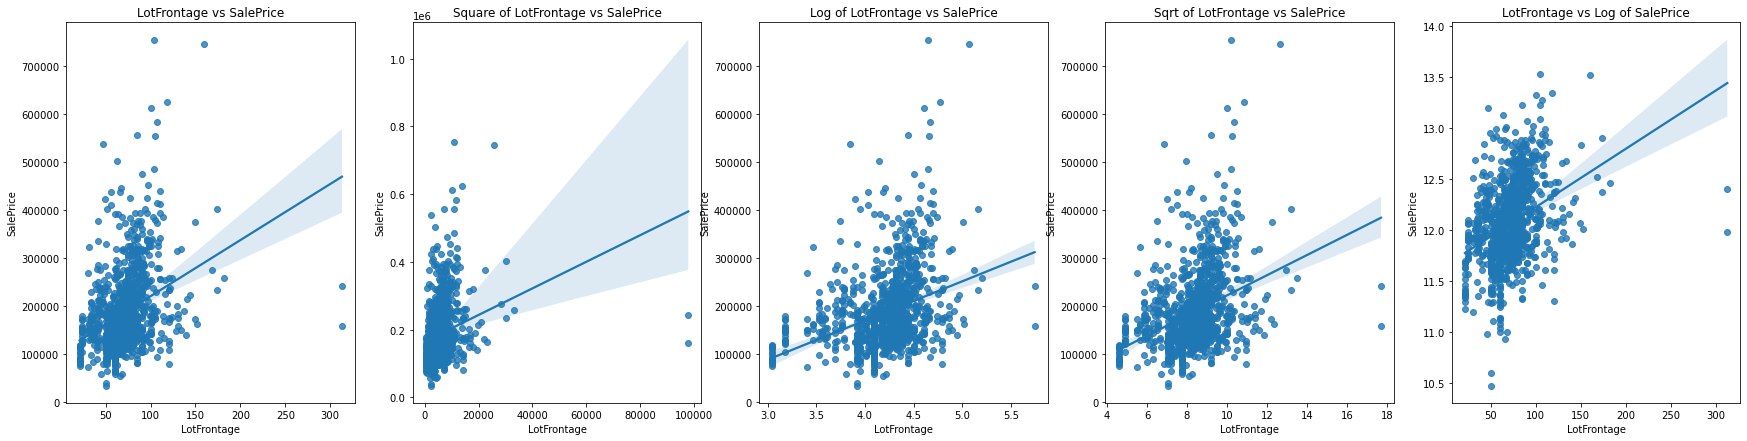

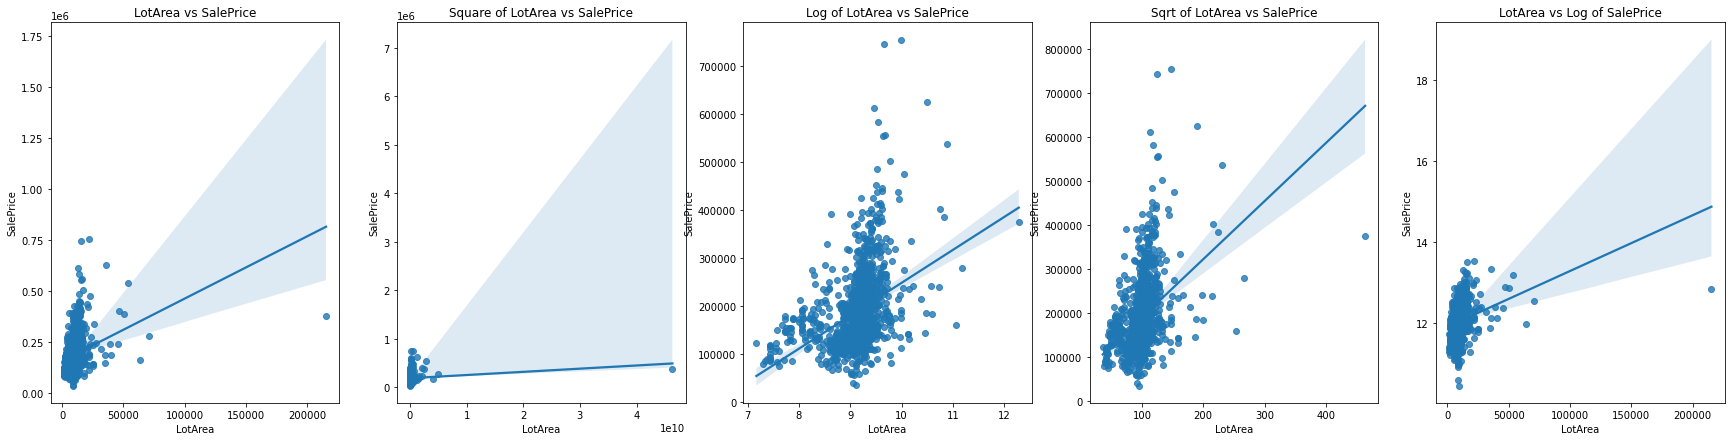

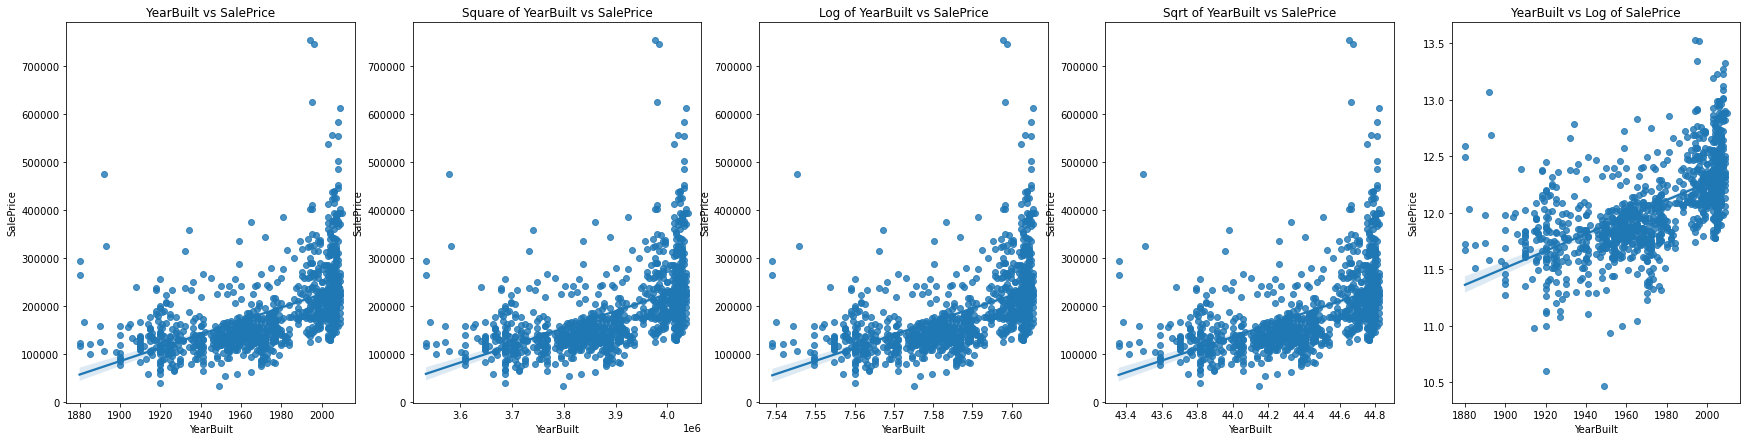

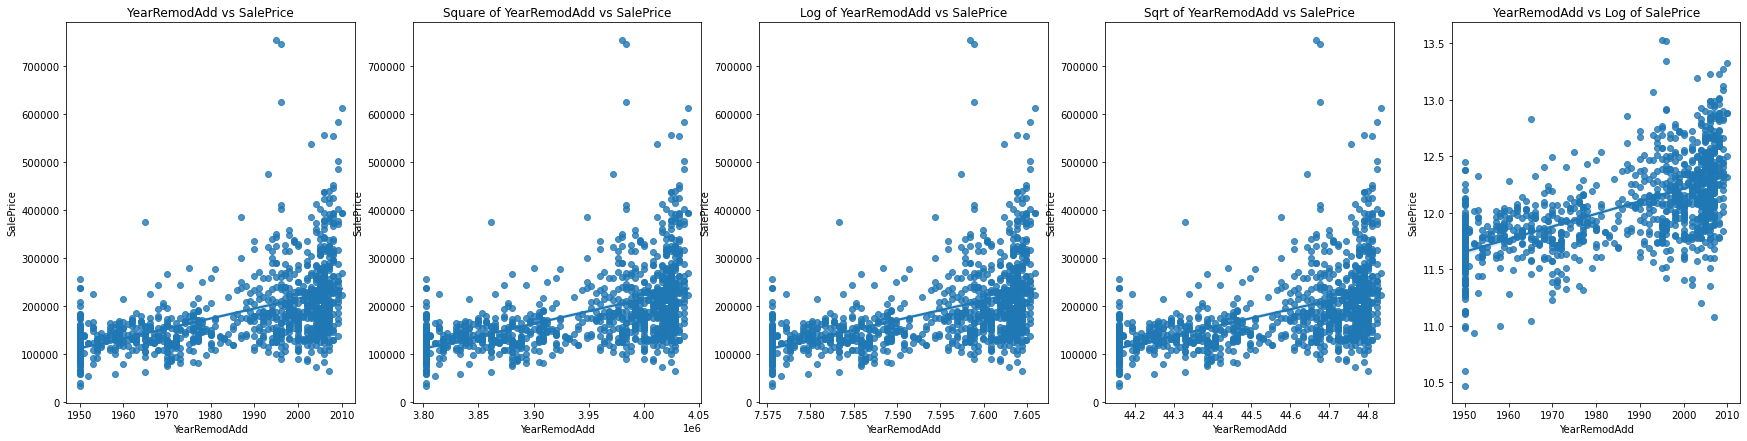

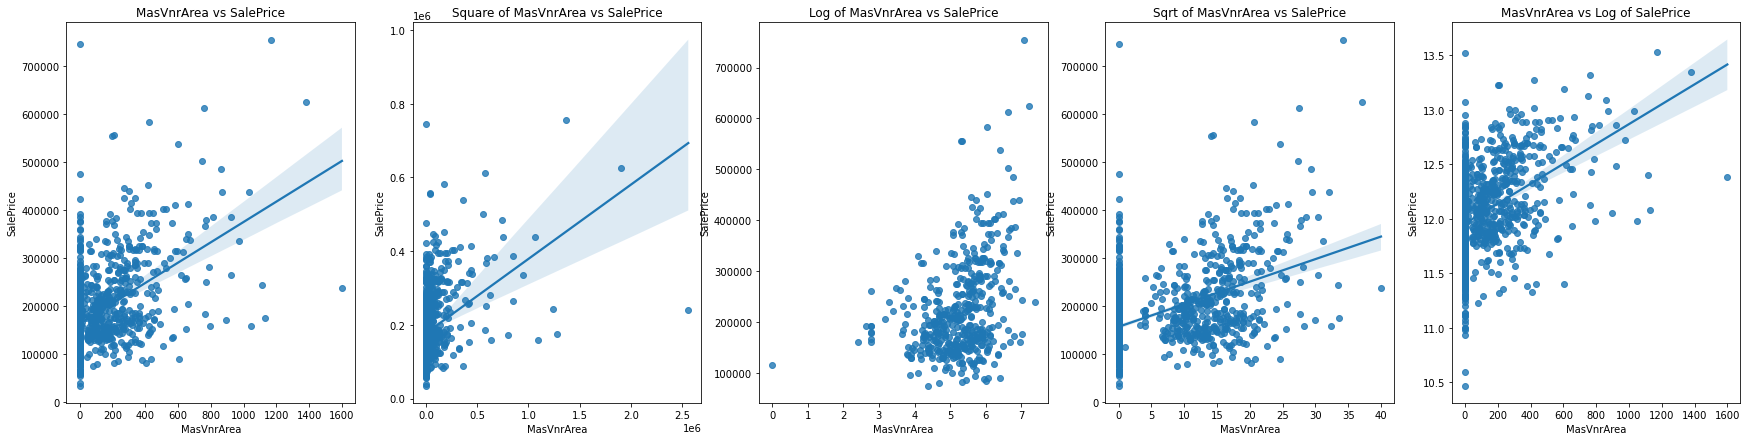

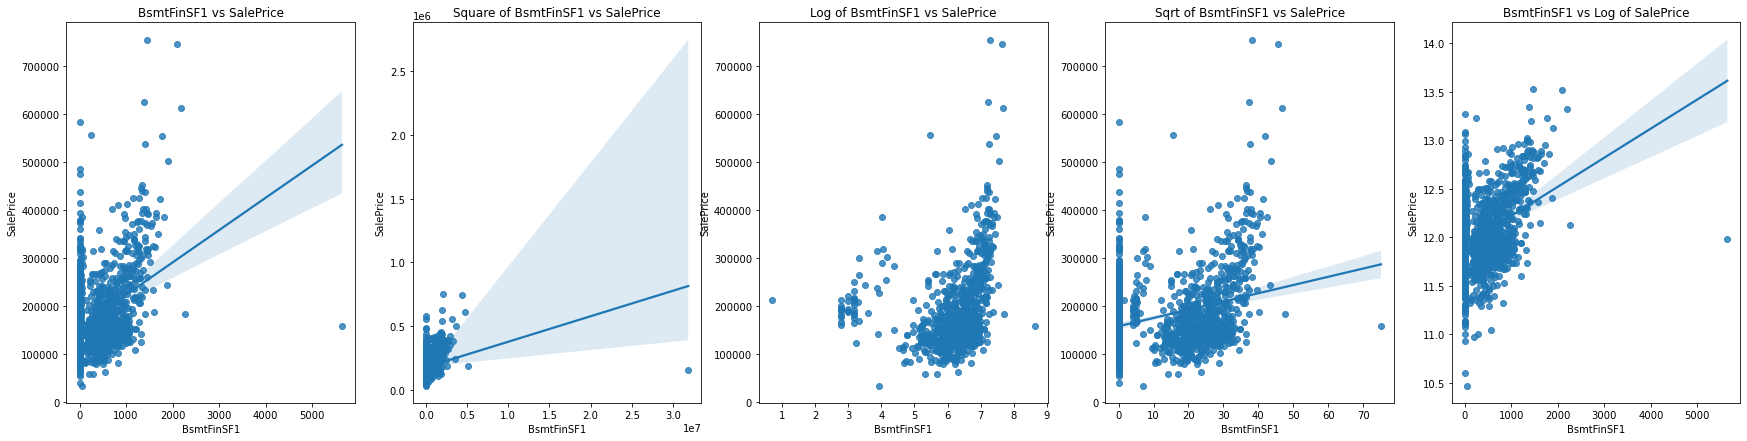

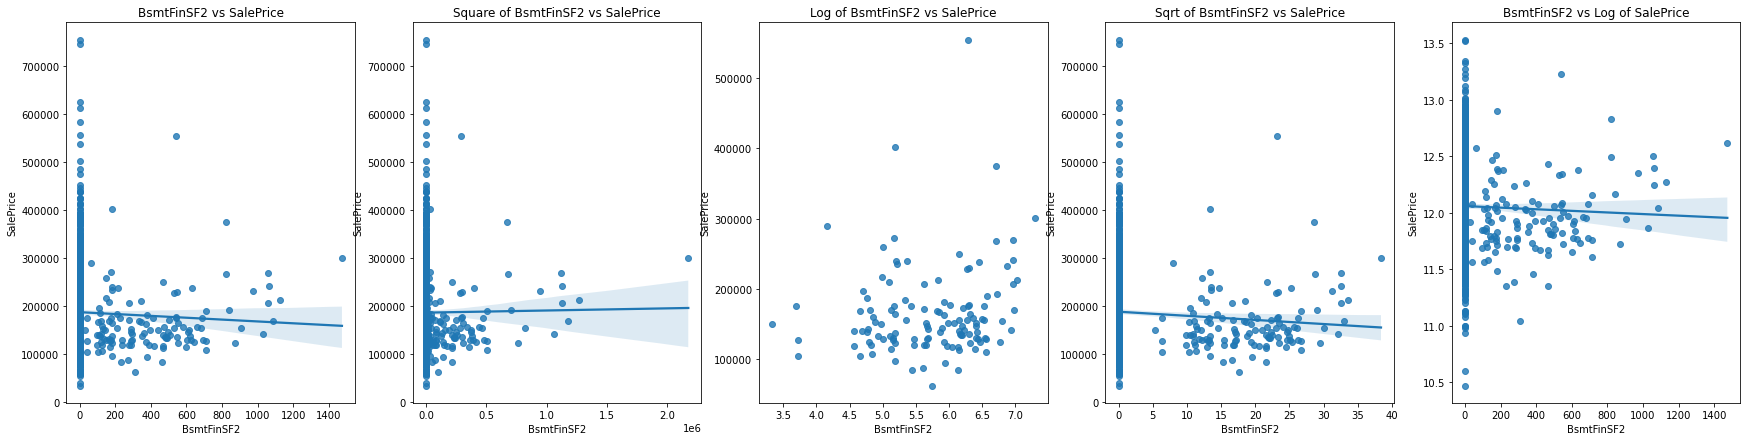

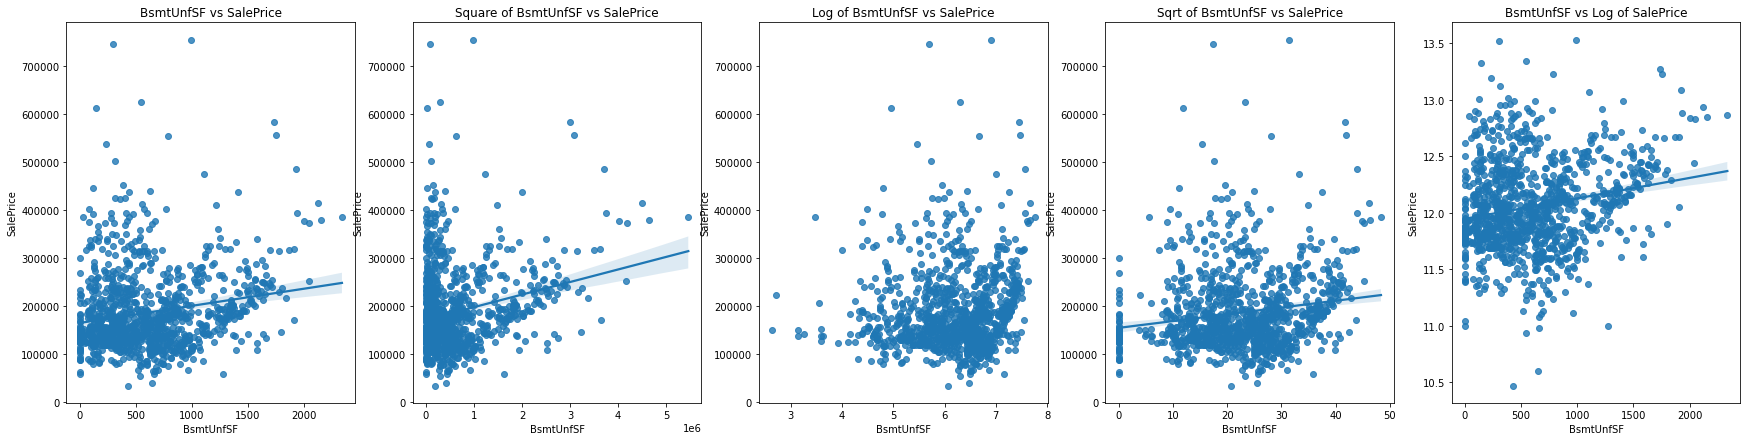

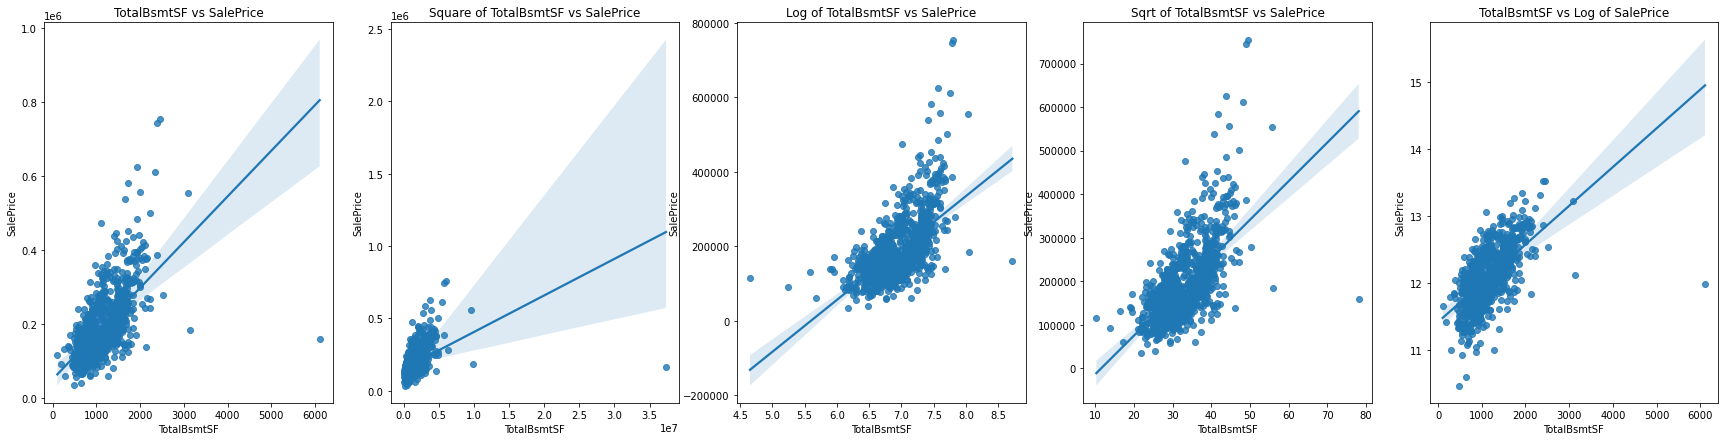

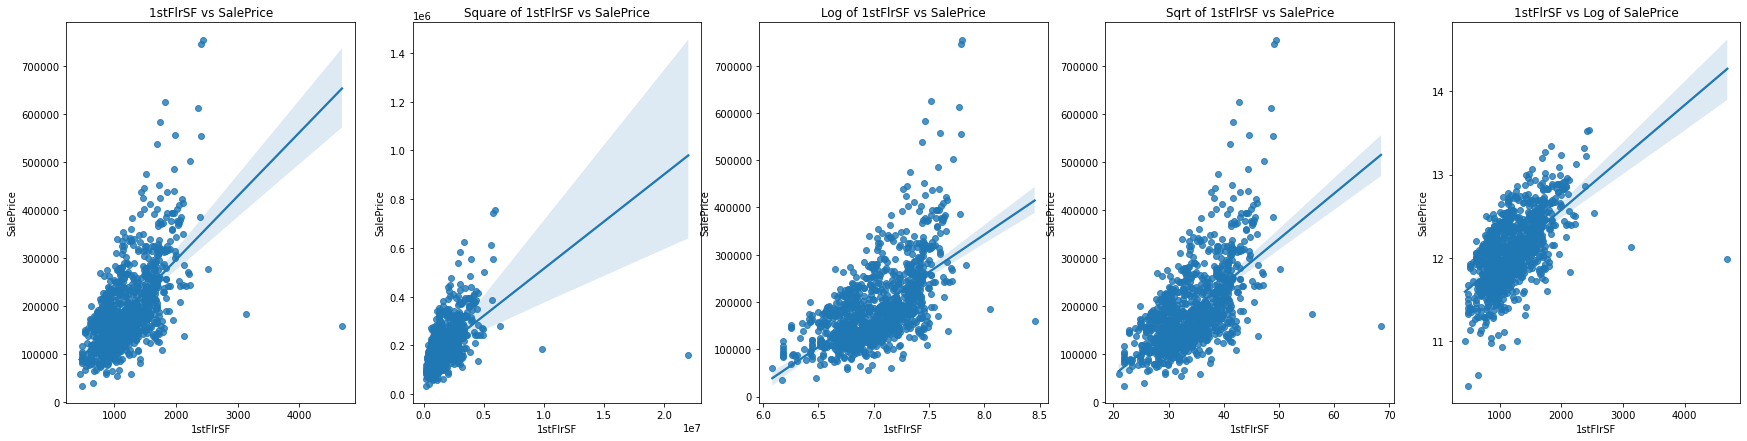

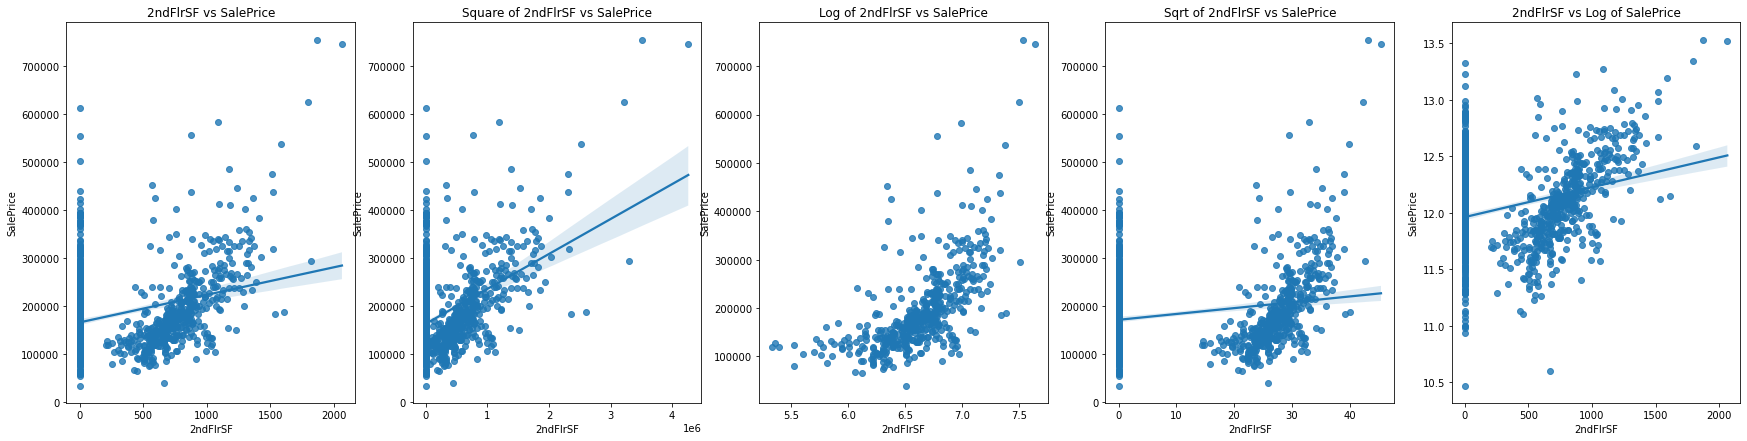

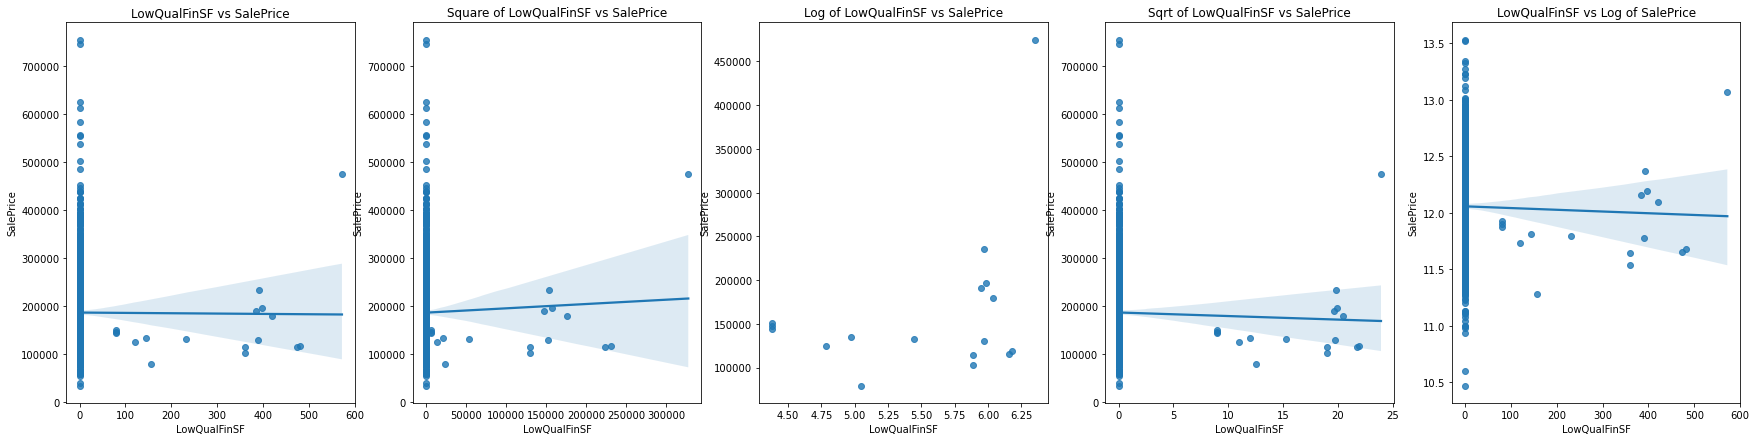

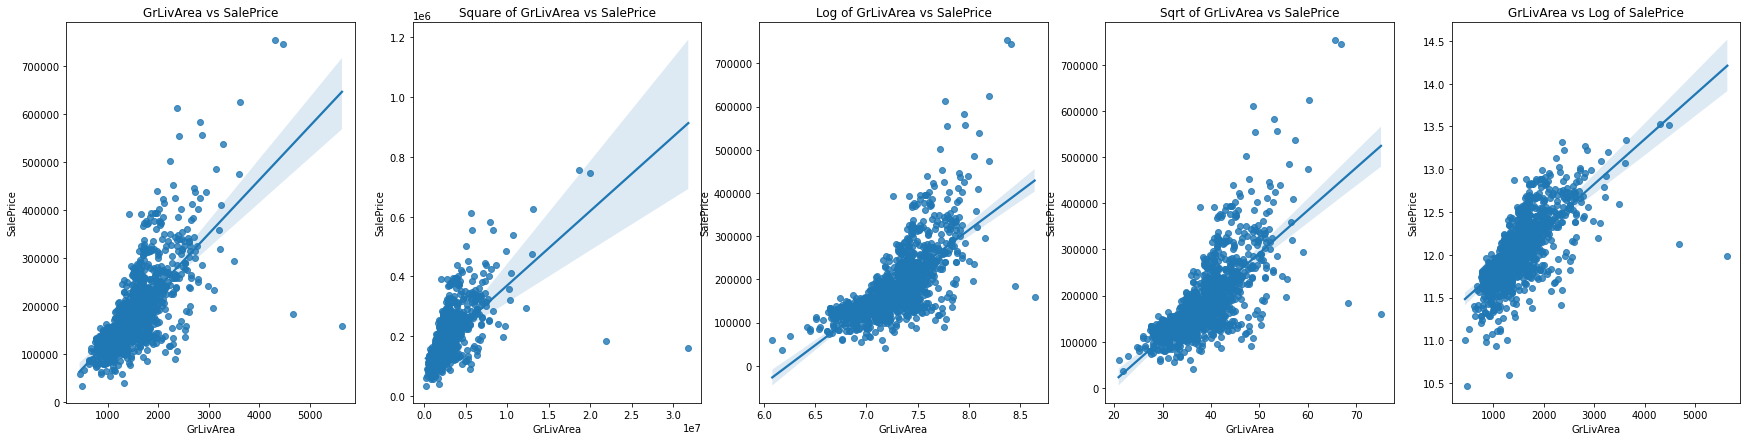

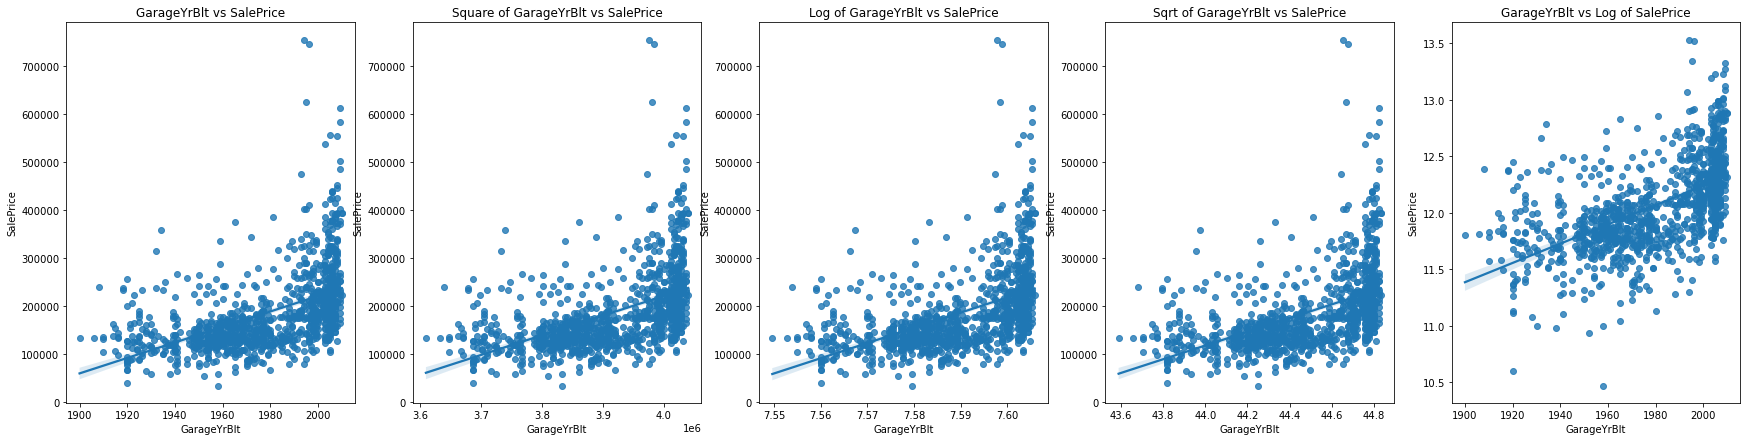

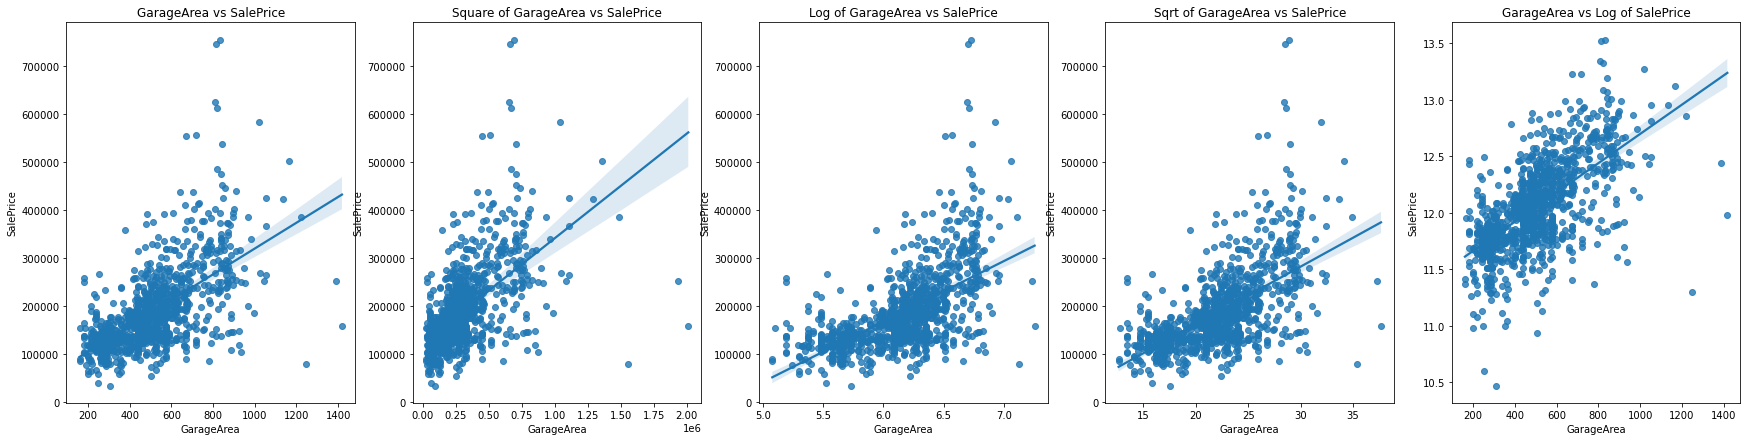

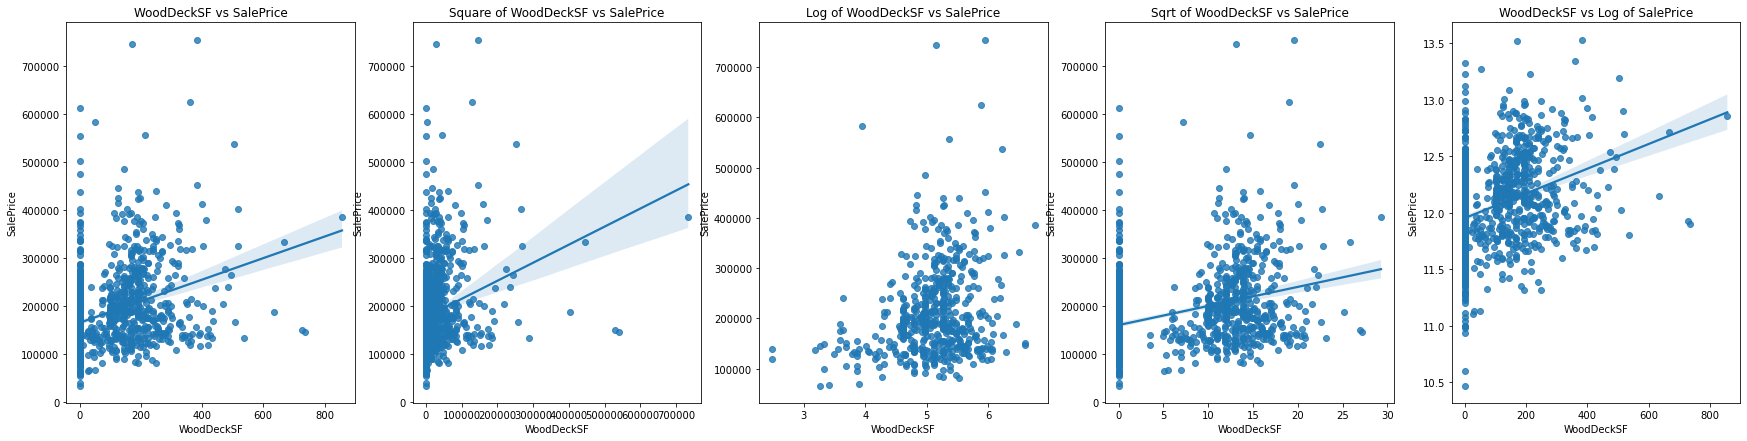

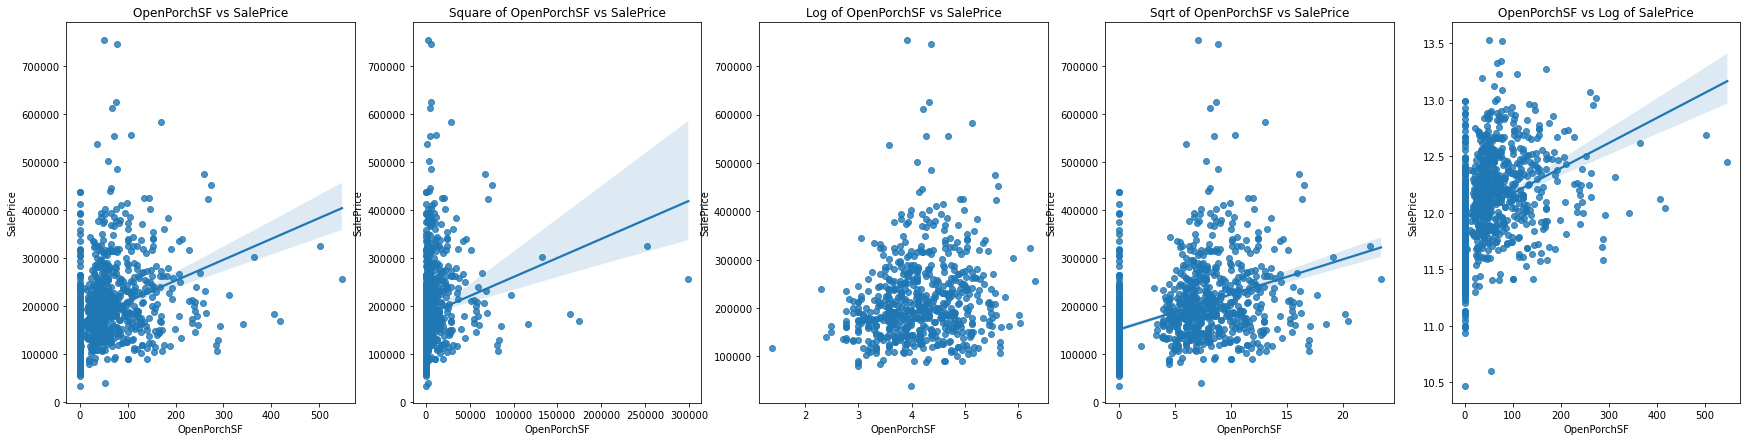

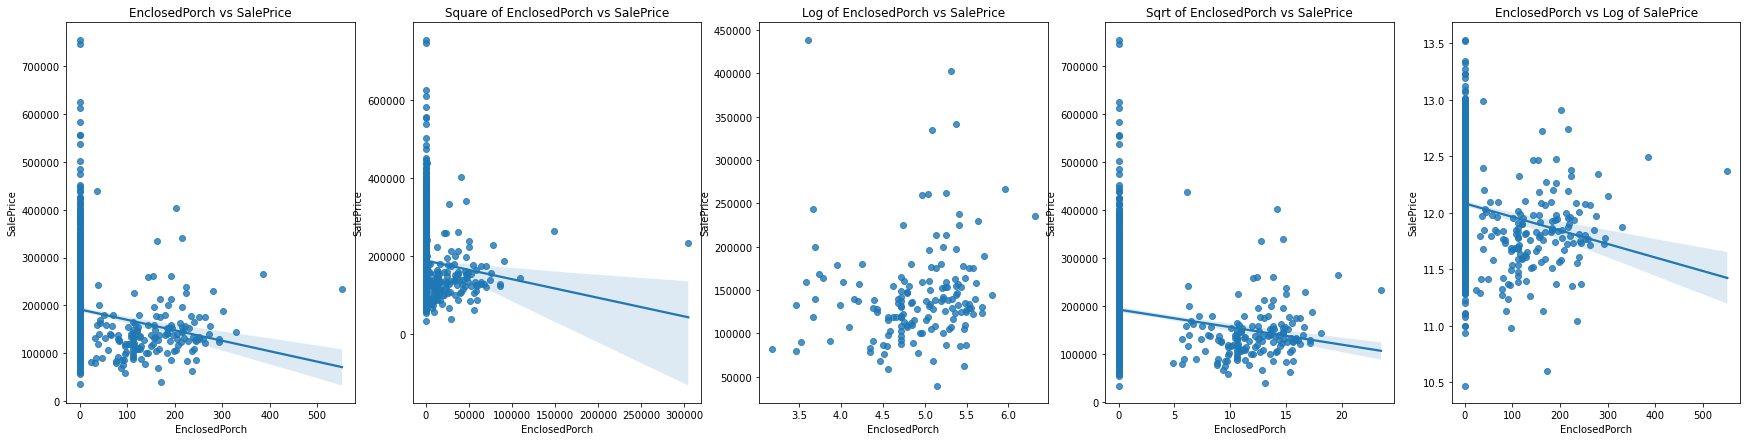

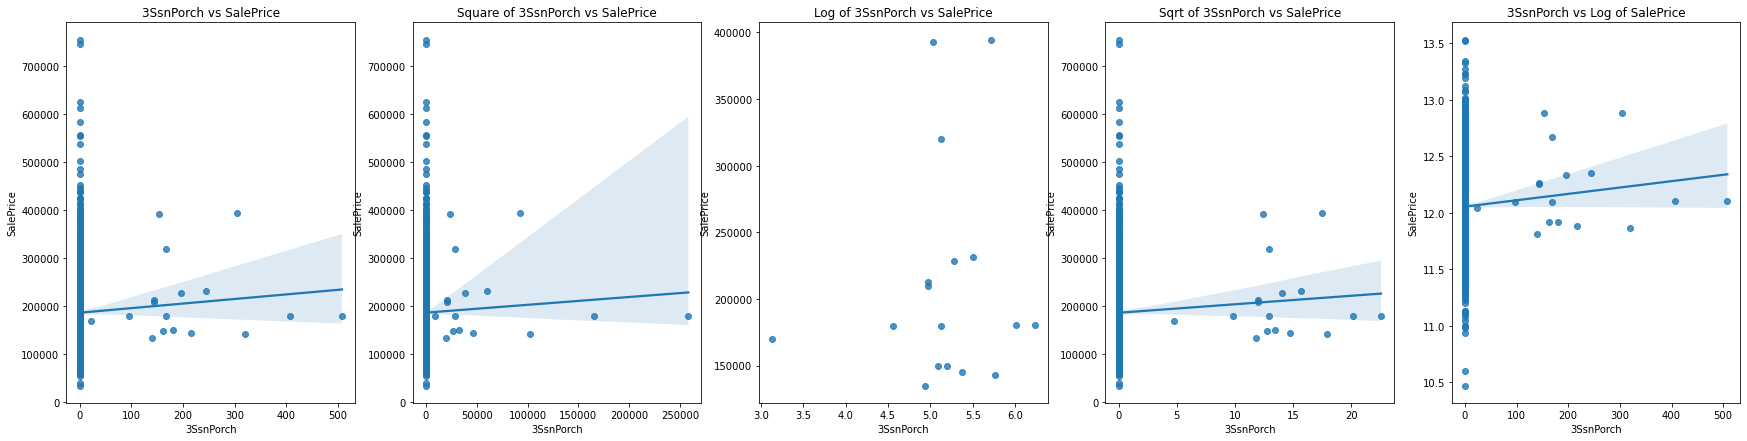

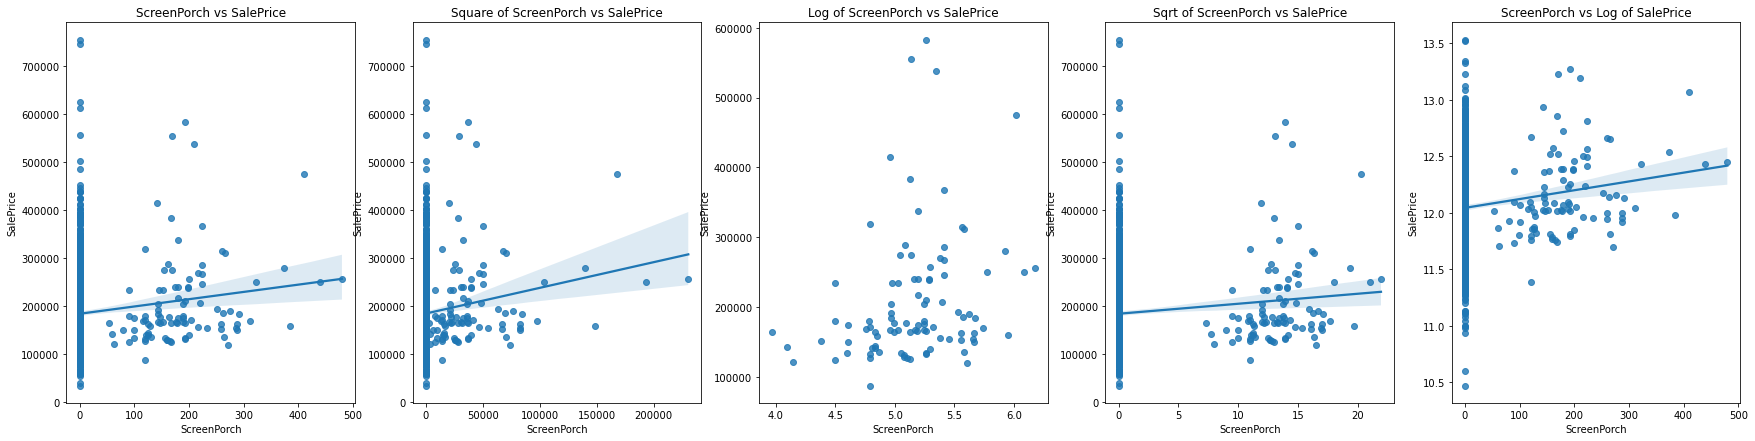

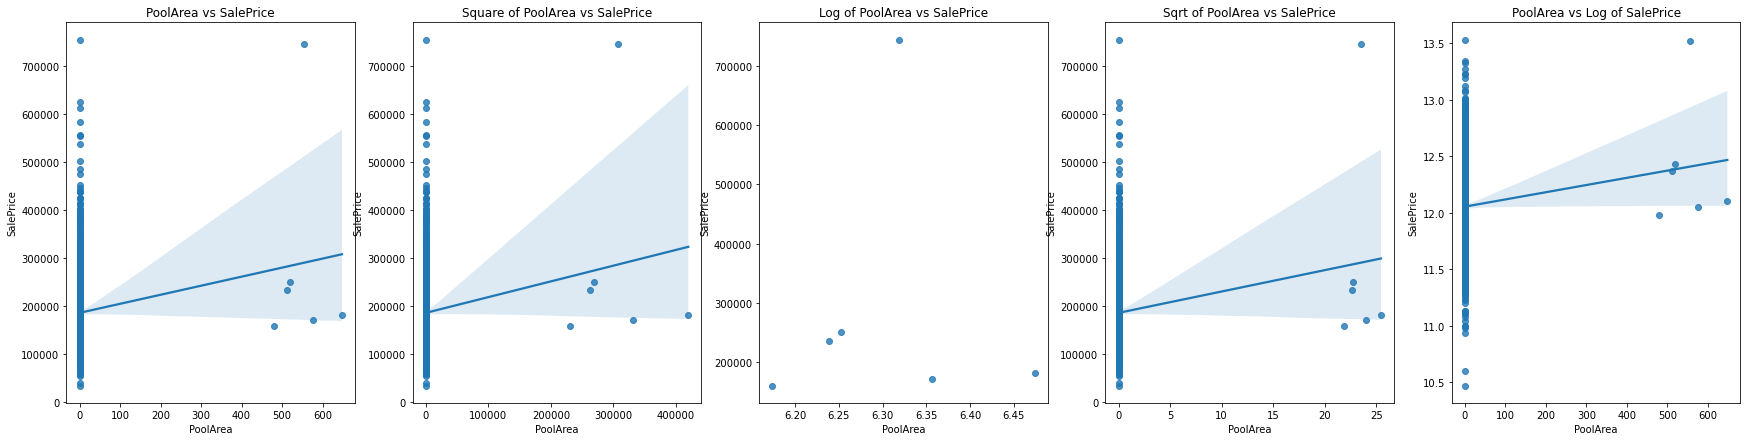

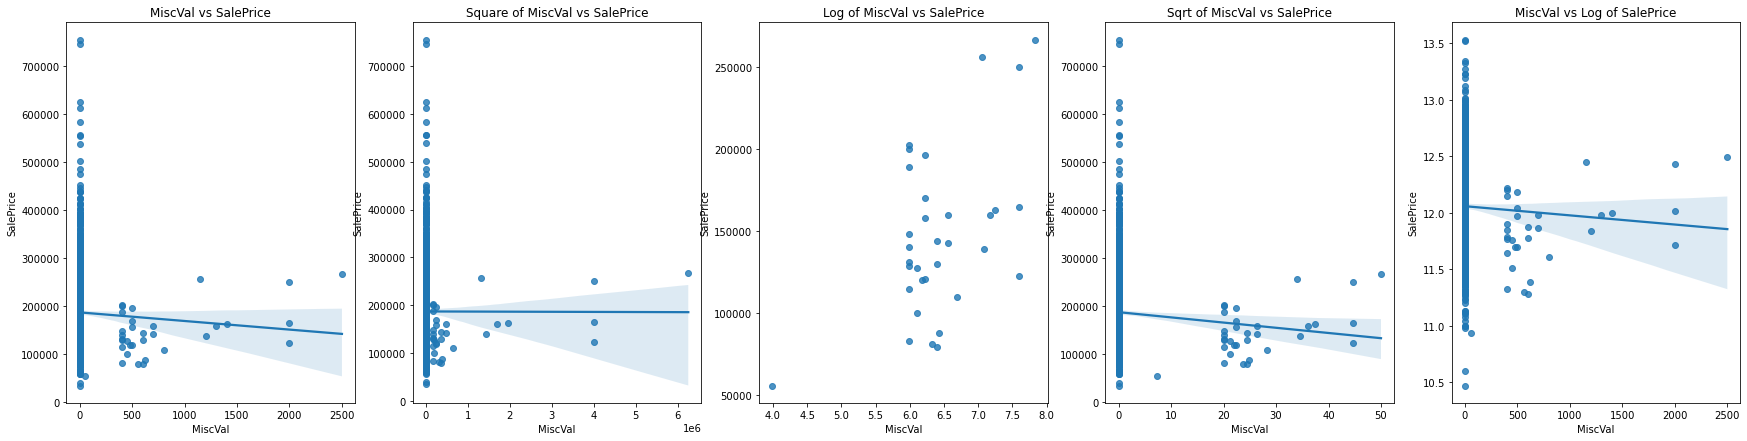

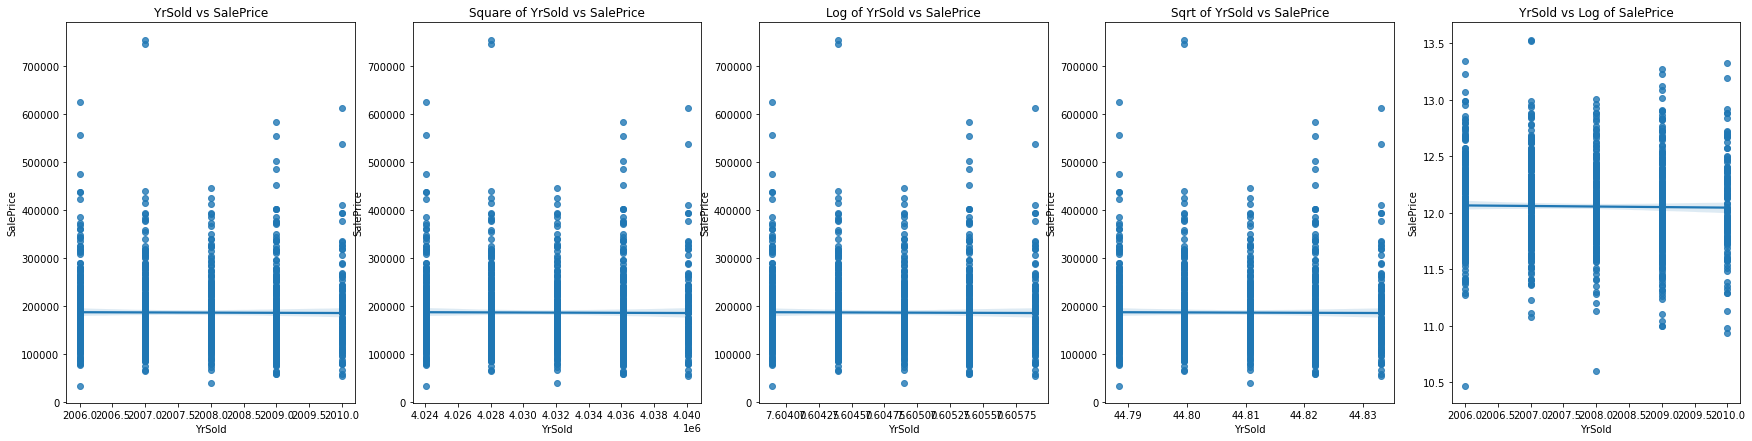

In [26]:
for col in cont_cols[:-1]:
    plot_transformations(col, "SalePrice", house_df)

# Pre-processing

### Get dummies

In [27]:
dummies_df = pd.get_dummies(house_df[cat_cols])

df = pd.concat([house_df, dummies_df], axis=1)
df.drop(cat_cols, axis=1, inplace=True)
df.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0         65.0     8450       2003          2003       196.0         706   
1         80.0     9600       1976          1976         0.0         978   
2         68.0    11250       2001          2002       162.0         486   
3         60.0     9550       1915          1970         0.0         216   
4         84.0    14260       2000          2000       350.0         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLw  \
0           0        150          856       856  ...               0   
1           0        284         1262      1262  ...               0   
2           0        434          920       920  ...               0   
3           0        540          756       961  ...               0   
4           0        490         1145      1145  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      1   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 247 columns]

### Train test split

In [28]:
features = df.columns.drop("SalePrice")
target = "SalePrice"

In [29]:
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)
print(df_train.shape)
print(df_test.shape)

(765, 247)
(329, 247)


In [30]:
X_train = df_train[features]
y_train = df_train[[target]]

X_test = df_test[features]
y_test = df_test[[target]]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(765, 246) (765, 1)
(329, 246) (329, 1)


### Scaling

In [31]:
X_train[cont_cols[:-1]].iloc[[0]]

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
290        120.0    15611       2006          2006         0.0           0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  GarageYrBlt  \
290           0       1079         1079      1079  ...       2006.0   

     GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
290         685           0           51              0          0   

     ScreenPorch  PoolArea  MiscVal  YrSold  
290            0         0        0    2006  

[1 rows x 23 columns]

In [32]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
#scaler = StandardScaler()

X_train[cont_cols[:-1]] = scalerX.fit_transform(X_train[cont_cols[:-1]])
X_train[cont_cols[:-1]].describe()

LotFrontage     LotArea   YearBuilt  YearRemodAdd  MasVnrArea  \
count   765.000000  765.000000  765.000000    765.000000  765.000000   
mean      0.174752    0.041673    0.712207      0.598105    0.078660   
std       0.086750    0.041405    0.236517      0.349191    0.131917   
min       0.000000    0.000000    0.000000      0.000000    0.000000   
25%       0.133562    0.030382    0.569231      0.283333    0.000000   
50%       0.167808    0.038753    0.723077      0.750000    0.000000   
75%       0.208904    0.047250    0.946154      0.916667    0.124093   
max       1.000000    1.000000    1.000000      1.000000    1.000000   

       BsmtFinSF1  BsmtFinSF2   BsmtUnfSF  TotalBsmtSF    1stFlrSF  ...  \
count  765.000000  765.000000  765.000000   765.000000  765.000000  ...   
mean     0.079310    0.034785    0.259457     0.166526    0.174573  ...   
std      0.083904    0.115273    0.190669     0.070371    0.091066  ...   
min      0.000000    0.000000    0.000000     0.000000    0.000000  ...   
25%      0.000000    0.000000    0.115582     0.119400    0.107193  ...   
50%      0.068746    0.000000    0.217466     0.153372    0.156794  ...   
75%      0.124734    0.000000    0.362158     0.207327    0.229431  ...   
max      1.000000    1.000000    1.000000     1.000000    1.000000  ...   

       GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count   765.000000  765.000000  765.000000   765.000000     765.000000   
mean      0.682863    0.274237    0.125426     0.087551       0.072368   
std       0.257779    0.152731    0.159077     0.120846       0.198788   
min       0.000000    0.000000    0.000000     0.000000       0.000000   
25%       0.500000    0.166932    0.000000     0.000000       0.000000   
50%       0.700000    0.257552    0.000000     0.053016       0.000000   
75%       0.930000    0.340223    0.230769     0.126143       0.000000   
max       1.000000    1.000000    1.000000     1.000000       1.000000   

        3SsnPorch  ScreenPorch    PoolArea     MiscVal      YrSold  
count  765.000000   765.000000  765.000000  765.000000  765.000000  
mean     0.006479     0.036879    0.004557    0.008802    0.453922  
std      0.058812     0.123761    0.063251    0.063039    0.333921  
min      0.000000     0.000000    0.000000    0.000000    0.000000  
25%      0.000000     0.000000    0.000000    0.000000    0.250000  
50%      0.000000     0.000000    0.000000    0.000000    0.500000  
75%      0.000000     0.000000    0.000000    0.000000    0.750000  
max      1.000000     1.000000    1.000000    1.000000    1.000000  

[8 rows x 23 columns]

In [33]:
X_train[cont_cols[:-1]].iloc[[0]]

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
290     0.339041  0.066891   0.969231      0.933333         0.0         0.0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  GarageYrBlt  \
290         0.0   0.461901     0.162198  0.150682  ...         0.96   

     GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
290    0.417329         0.0     0.093236            0.0        0.0   

     ScreenPorch  PoolArea  MiscVal  YrSold  
290          0.0       0.0      0.0     0.0  

[1 rows x 23 columns]

In [34]:
#y_train = scalerY.fit_transform(y_train).reshape(-1)
y_train[:5]

SalePrice
290      233230
546      210000
891      172500
1393     163000
605      205000

In [35]:
X_test[cont_cols[:-1]].iloc[[0]]

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
202         50.0     7000       1924          1950         0.0         617   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  GarageYrBlt  \
202           0          0          617       865  ...       1924.0   

     GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
202         398           0            0            126          0   

     ScreenPorch  PoolArea  MiscVal  YrSold  
202            0         0        0    2006  

[1 rows x 23 columns]

In [36]:
X_test[cont_cols[:-1]] = scalerX.transform(X_test[cont_cols[:-1]])
X_test[cont_cols[:-1]].describe()

LotFrontage     LotArea   YearBuilt  YearRemodAdd  MasVnrArea  \
count   329.000000  329.000000  329.000000    329.000000  329.000000   
mean      0.160314    0.040377    0.707739      0.599747    0.082188   
std       0.076164    0.030255    0.247994      0.348571    0.152492   
min       0.000000    0.001384    0.000000      0.000000    0.000000   
25%       0.109589    0.027577    0.553846      0.300000    0.000000   
50%       0.157534    0.036551    0.738462      0.750000    0.000000   
75%       0.202055    0.046498    0.946154      0.900000    0.127721   
max       0.523973    0.324668    0.992308      1.000000    1.161103   

       BsmtFinSF1  BsmtFinSF2   BsmtUnfSF  TotalBsmtSF    1stFlrSF  ...  \
count  329.000000  329.000000  329.000000   329.000000  329.000000  ...   
mean     0.079645    0.021202    0.259493     0.163521    0.169239  ...   
std      0.081150    0.087924    0.191574     0.066631    0.091317  ...   
min      0.000000    0.000000    0.000000     0.026478    0.009873  ...   
25%      0.000000    0.000000    0.117295     0.116403    0.103667  ...   
50%      0.066265    0.000000    0.238014     0.147710    0.152327  ...   
75%      0.129695    0.000000    0.362158     0.201665    0.226610  ...   
max      0.400425    0.721167    0.921661     0.505079    0.634697  ...   

       GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count   329.000000  329.000000  329.000000   329.000000     329.000000   
mean      0.692158    0.270988    0.139275     0.081817       0.082005   
std       0.263230    0.153273    0.188328     0.112938       0.234604   
min      -0.100000    0.000000    0.000000     0.000000       0.000000   
25%       0.500000    0.141494    0.000000     0.000000       0.000000   
50%       0.780000    0.257552    0.000000     0.042048       0.000000   
75%       0.930000    0.363275    0.247253     0.124314       0.000000   
max       0.990000    0.709062    1.177198     0.742230       1.883959   

        3SsnPorch  ScreenPorch    PoolArea     MiscVal      YrSold  
count  329.000000   329.000000  329.000000  329.000000  329.000000  
mean     0.006318     0.028540    0.004836    0.010857    0.429331  
std      0.057445     0.117028    0.061932    0.075063    0.332647  
min      0.000000     0.000000    0.000000    0.000000    0.000000  
25%      0.000000     0.000000    0.000000    0.000000    0.250000  
50%      0.000000     0.000000    0.000000    0.000000    0.500000  
75%      0.000000     0.000000    0.000000    0.000000    0.750000  
max      0.801181     0.916667    0.800926    0.800000    1.000000  

[8 rows x 23 columns]

In [37]:
X_test[cont_cols[:-1]].iloc[[0]]

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
202     0.099315  0.026642   0.338462           0.0         0.0     0.10932   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  GarageYrBlt  \
202         0.0        0.0     0.085262  0.100376  ...         0.14   

     GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
202    0.189189         0.0          0.0       0.430034        0.0   

     ScreenPorch  PoolArea  MiscVal  YrSold  
202          0.0       0.0      0.0     0.0  

[1 rows x 23 columns]

In [38]:
#y_test = scalerY.transform(y_test).reshape(-1)
y_test[:5]

SalePrice
202      112000
1125     115000
219      167240
1333     125500
400      245500

# Model Building

## Linear Regression

In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lr_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lr_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','MSE (Train)','MSE (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metrics
}
lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

                 Train          Test
R2_Score  9.459477e-01 -2.513022e+18
MSE       3.708559e+08  1.765121e+28
RMSE      1.925762e+04  1.328579e+14


#### Residual Analysis

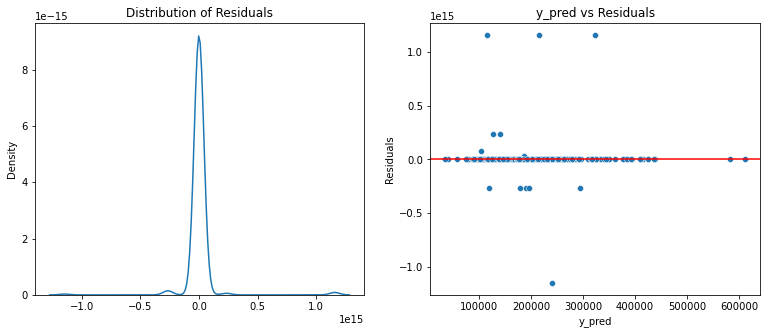

In [40]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

## Ridge

In [41]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

print(model_cv.best_params_)

best_ridge_model = Ridge(alpha=model_cv.best_params_['alpha'])
best_ridge_model.fit(X_train, y_train)

y_train_pred = best_ridge_model.predict(X_train)
y_test_pred = best_ridge_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

rg_metric = pd.Series(metrics, name = 'Ridge Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 0.1}
                 Train          Test
R2_Score  9.437620e-01  7.763810e-01
MSE       3.858523e+08  1.570678e+09
RMSE      1.964312e+04  3.963178e+04


#### Residual Analysis

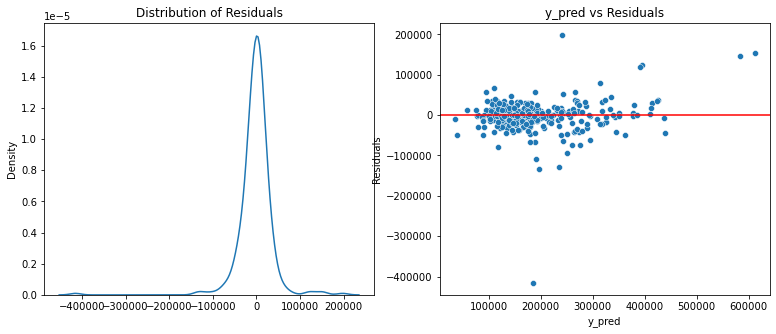

In [42]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

## Lasso

In [43]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

model_cv.best_params_

best_lasso_model = Lasso(alpha=model_cv.best_params_["alpha"])
best_lasso_model.fit(X_train, y_train)

y_train_pred = best_lasso_model.predict(X_train)
y_test_pred = best_lasso_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lasso_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lasso_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

ls_metric = pd.Series(metrics, name = 'Lasso Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
                 Train          Test
R2_Score  9.246594e-01  8.171133e-01
MSE       5.169163e+08  1.284578e+09
RMSE      2.273579e+04  3.584101e+04


### Residual analysis

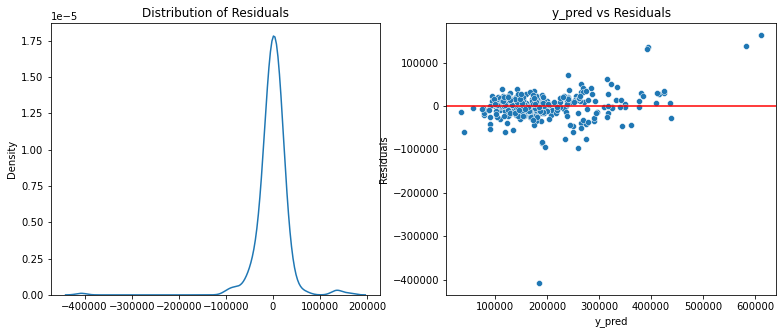

In [44]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

# Compare Metrics

In [45]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)
final_metric

Metric                   Linear Regression  Ridge Regression  \
0  R2 Score (Train)                             0.94595           0.94376   
1   R2 Score (Test)          -2513021838254185984.00000           0.77638   
2       MSE (Train)                     370855930.61176   385852305.76520   
3        MSE (Test) 17651214863345913654327377920.00000  1570677822.55804   
4      RMSE (Train)                         19257.62007       19643.12363   
5       RMSE (Test)               132857874675707.17188       39631.77794   

   Lasso Regression  
0           0.92466  
1           0.81711  
2   516916326.84291  
3  1284578140.82182  
4       22735.79396  
5       35841.01199

## Top 10 features & Coeff

In [46]:
get_top_1o_features(X_train, lr_model, best_ridge_model, best_lasso_model)

LR                LR_coeff             Ridge   Ridge_coeff  \
0    Foundation_Wood -5015357357641035.00000  RoofMatl_ClyTile -513240.59732   
1   Foundation_Stone -5015357357597122.00000           LotArea  175685.29539   
2   Foundation_PConc -5015357357591397.00000  RoofMatl_WdShngl  160180.50791   
3  Foundation_BrkTil -5015357357591208.00000         GrLivArea  143568.23549   
4  Foundation_CBlock -5015357357589646.00000          2ndFlrSF  127928.75525   
5          GrLivArea  3239835509895071.00000  RoofMatl_CompShg  111430.19177   
6       ExterQual_TA -2688897675296930.50000          1stFlrSF  109914.23310   
7       ExterQual_Gd -2688897675292035.00000       TotalBsmtSF  107165.73107   
8       ExterQual_Fa -2688897675290032.50000        BsmtFinSF1  105166.68213   
9       ExterQual_Ex -2688897675272508.00000     RoofMatl_Roll   94370.68528   

                  Lasso   Lasso_coeff  
0      RoofMatl_ClyTile -473650.96449  
1             GrLivArea  366761.77230  
2               LotArea   73636.88114  
3      RoofMatl_WdShngl   62181.60405  
4  Neighborhood_NoRidge   49180.26793  
5  Neighborhood_StoneBr   46295.00461  
6            BsmtFinSF1   36882.61451  
7              PoolArea   35116.88331  
8           BsmtQual_Ex   32136.30703  
9        KitchenQual_Ex   30299.91915

In [47]:
df1 = df.copy()

# Repeat with features transformed with linearity

### Log transformations

In [48]:
log_cols = ["LotFrontage", "LotArea", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageArea"]

for col in log_cols:
    df[col + "Log"] = np.log(df[col])

log_cols = [ col+'Log' for col in log_cols]

### Square-root transformations

In [49]:
sqrt_cols = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "2ndFlrSF", 
                "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "MiscVal" ]

for col in sqrt_cols:
    df[col + "Sqrt"] = np.sqrt(df[col])
    df[col + "Sqrt"] = np.sqrt(df[col])

sqrt_cols = [ col+'Sqrt' for col in sqrt_cols]

In [50]:
features = df.columns.drop("SalePrice")
target = "SalePrice"

df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)
print(df_train.shape)
print(df_test.shape)

X_train = df_train[features]
y_train = df_train[[target]]

X_test = df_test[features]
y_test = df_test[[target]]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(765, 263)
(329, 263)
(765, 262) (765, 1)
(329, 262) (329, 1)


#### Scaling

In [51]:
new_cont_cols = sqrt_cols + log_cols + cont_cols

X_test[new_cont_cols[:-1]].iloc[[0]]

MasVnrAreaSqrt  BsmtFinSF1Sqrt  BsmtFinSF2Sqrt  BsmtUnfSFSqrt  \
202         0.00000        24.83948         0.00000        0.00000   

     2ndFlrSFSqrt  WoodDeckSFSqrt  OpenPorchSFSqrt  EnclosedPorchSqrt  \
202      21.09502         0.00000          0.00000           11.22497   

     ScreenPorchSqrt  MiscValSqrt  ...  GarageYrBlt  GarageArea  WoodDeckSF  \
202          0.00000      0.00000  ...   1924.00000         398           0   

     OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
202            0            126          0            0         0        0   

     YrSold  
202    2006  

[1 rows x 39 columns]

In [52]:
scalerX = MinMaxScaler()
#scaler = StandardScaler()

X_train[new_cont_cols[:-1]] = scalerX.fit_transform(X_train[new_cont_cols[:-1]])
X_train[cont_cols[:-1]].describe()

X_test[new_cont_cols[:-1]] = scalerX.transform(X_test[new_cont_cols[:-1]])
X_test[new_cont_cols[:-1]].describe()

MasVnrAreaSqrt  BsmtFinSF1Sqrt  BsmtFinSF2Sqrt  BsmtUnfSFSqrt  \
count       329.00000       329.00000       329.00000      329.00000   
mean          0.16505         0.21899         0.03938        0.46571   
std           0.23476         0.17828         0.14040        0.20673   
min           0.00000         0.00000         0.00000        0.00000   
25%           0.00000         0.00000         0.00000        0.34248   
50%           0.00000         0.25742         0.00000        0.48787   
75%           0.35738         0.36013         0.00000        0.60180   
max           1.07754         0.63279         0.84922        0.96003   

       2ndFlrSFSqrt  WoodDeckSFSqrt  OpenPorchSFSqrt  EnclosedPorchSqrt  \
count     329.00000       329.00000        329.00000          329.00000   
mean        0.27643         0.25067          0.19730            0.10657   
std         0.31531         0.27690          0.20741            0.26620   
min         0.00000         0.00000          0.00000            0.00000   
25%         0.00000         0.00000          0.00000            0.00000   
50%         0.00000         0.00000          0.20505            0.00000   
75%         0.59538         0.49725          0.35258            0.00000   
max         0.93829         1.08499          0.86153            1.37257   

       ScreenPorchSqrt  MiscValSqrt  ...  GarageYrBlt  GarageArea  WoodDeckSF  \
count        329.00000    329.00000  ...    329.00000   329.00000   329.00000   
mean           0.04267      0.01723  ...      0.69216     0.27099     0.13927   
std            0.16371      0.10292  ...      0.26323     0.15327     0.18833   
min            0.00000      0.00000  ...     -0.10000     0.00000     0.00000   
25%            0.00000      0.00000  ...      0.50000     0.14149     0.00000   
50%            0.00000      0.00000  ...      0.78000     0.25755     0.00000   
75%            0.00000      0.00000  ...      0.93000     0.36328     0.24725   
max            0.95743      0.89443  ...      0.99000     0.70906     1.17720   

       OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal  \
count    329.00000      329.00000  329.00000    329.00000 329.00000 329.00000   
mean       0.08182        0.08200    0.00632      0.02854   0.00484   0.01086   
std        0.11294        0.23460    0.05745      0.11703   0.06193   0.07506   
min        0.00000        0.00000    0.00000      0.00000   0.00000   0.00000   
25%        0.00000        0.00000    0.00000      0.00000   0.00000   0.00000   
50%        0.04205        0.00000    0.00000      0.00000   0.00000   0.00000   
75%        0.12431        0.00000    0.00000      0.00000   0.00000   0.00000   
max        0.74223        1.88396    0.80118      0.91667   0.80093   0.80000   

         YrSold  
count 329.00000  
mean    0.42933  
std     0.33265  
min     0.00000  
25%     0.25000  
50%     0.50000  
75%     0.75000  
max     1.00000  

[8 rows x 39 columns]

In [53]:
X_test[new_cont_cols[:-1]].iloc[[0]]

MasVnrAreaSqrt  BsmtFinSF1Sqrt  BsmtFinSF2Sqrt  BsmtUnfSFSqrt  \
202         0.00000         0.33064         0.00000        0.00000   

     2ndFlrSFSqrt  WoodDeckSFSqrt  OpenPorchSFSqrt  EnclosedPorchSqrt  \
202       0.46422         0.00000          0.00000            0.65577   

     ScreenPorchSqrt  MiscValSqrt  ...  GarageYrBlt  GarageArea  WoodDeckSF  \
202          0.00000      0.00000  ...      0.14000     0.18919     0.00000   

     OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
202      0.00000        0.43003    0.00000      0.00000   0.00000  0.00000   

     YrSold  
202 0.00000  

[1 rows x 39 columns]

### Linear

In [54]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lr_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lr_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','MSE (Train)','MSE (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metrics
}
lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

                   Train                                  Test
R2_Score         0.95535          -391137231060961067008.00000
MSE      306367747.26013 2747308917660457370014330126336.00000
RMSE         17503.36388                1657500804723924.50000


#### Residual Analysis

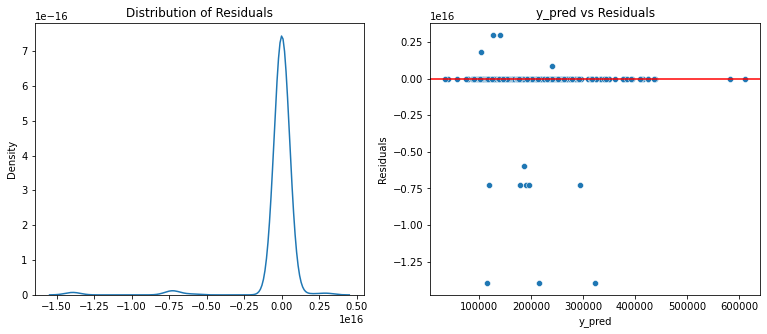

In [55]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

### Ridge

In [56]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

print(model_cv.best_params_)

best_ridge_model = Ridge(alpha=model_cv.best_params_['alpha'])
best_ridge_model.fit(X_train, y_train)

y_train_pred = best_ridge_model.predict(X_train)
y_test_pred = best_ridge_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

rg_metric = pd.Series(metrics, name = 'Ridge Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 5.0}
                   Train             Test
R2_Score         0.89776          0.82875
MSE      701459508.91341 1202843109.41684
RMSE         26485.08087      34682.02862


#### Residual Analysis

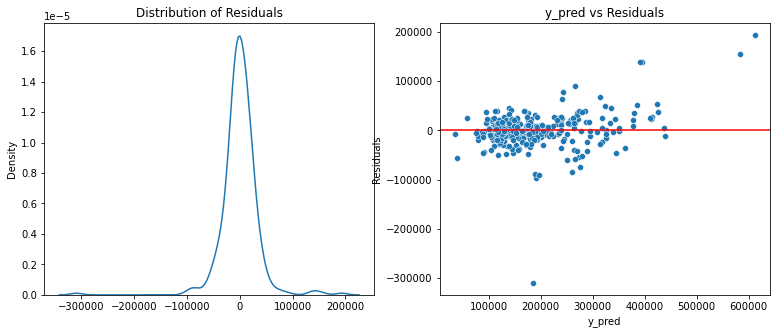

In [57]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

### Lasso

In [58]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

model_cv.best_params_

best_lasso_model = Lasso(alpha=model_cv.best_params_["alpha"])
best_lasso_model.fit(X_train, y_train)

y_train_pred = best_lasso_model.predict(X_train)
y_test_pred = best_lasso_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lasso_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lasso_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

ls_metric = pd.Series(metrics, name = 'Lasso Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
                   Train             Test
R2_Score         0.92417          0.81972
MSE      520301444.02438 1266251256.51414
RMSE         22810.11714      35584.42435


In [98]:
best_lasso_model.alpha

0.001

#### Residual Analysis

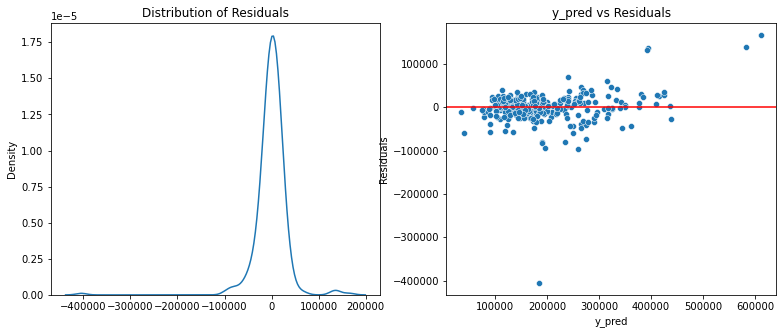

In [59]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

### Compare Metrics

In [60]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)
final_metric

Metric                     Linear Regression  Ridge Regression  \
0  R2 Score (Train)                               0.95535           0.89776   
1   R2 Score (Test)          -391137231060961067008.00000           0.82875   
2       MSE (Train)                       306367747.26013   701459508.91341   
3        MSE (Test) 2747308917660457370014330126336.00000  1202843109.41684   
4      RMSE (Train)                           17503.36388       26485.08087   
5       RMSE (Test)                1657500804723924.50000       34682.02862   

   Lasso Regression  
0           0.92417  
1           0.81972  
2   520301444.02438  
3  1266251256.51414  
4       22810.11714  
5       35584.42435

### Top10 featues & Coeff

In [61]:
get_top_1o_features(X_train, lr_model, best_ridge_model, best_lasso_model)

LR                 LR_coeff                 Ridge  \
0  GarageFinish_Fin -63917407013979648.00000              2ndFlrSF   
1  GarageFinish_Unf -63917407013979416.00000      RoofMatl_ClyTile   
2  GarageFinish_RFn -63917407013978216.00000  Neighborhood_NoRidge   
3      LotShape_IR2  39305910322068896.00000           1stFlrSFLog   
4      LotShape_IR3  39305910322063280.00000             GrLivArea   
5      LotShape_IR1  39305910322062720.00000      RoofMatl_WdShngl   
6      LotShape_Reg  39305910322060400.00000          GrLivAreaLog   
7    KitchenQual_Gd -36106820006441368.00000  Neighborhood_StoneBr   
8    KitchenQual_Fa -36106820006438768.00000          2ndFlrSFSqrt   
9    KitchenQual_TA -36106820006437600.00000           BsmtQual_Ex   

   Ridge_coeff                 Lasso   Lasso_coeff  
0  56644.59814      RoofMatl_ClyTile -448940.56351  
1 -50064.19647             GrLivArea  358246.20139  
2  48286.32701      RoofMatl_WdShngl   64511.54615  
3  45767.85617  Neighborhood_NoRidge   47713.35558  
4  43557.36475  Neighborhood_StoneBr   46045.11405  
5  41692.73767               LotArea   37806.61513  
6  39783.91379              PoolArea   35217.00368  
7  35026.87537            LotAreaLog   34358.08708  
8  29131.13469        BsmtFinSF1Sqrt   32534.35372  
9  26668.06493           BsmtQual_Ex   31873.10474

# Repeat with logged Y values

In [62]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### Linear

In [63]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lr_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lr_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','MSE (Train)','MSE (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metrics
}
lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

           Train                         Test
R2_Score 0.95228 -210715629916405039104.00000
MSE      0.00720   35232242202696896512.00000
RMSE     0.08484             5935675378.81722


#### Residual Analysis

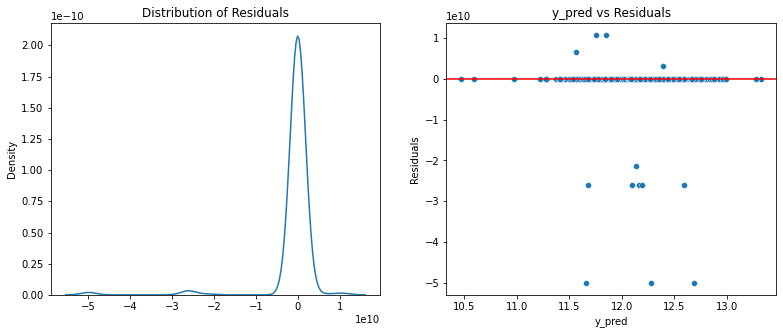

In [64]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

### Ridge

In [65]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

print(model_cv.best_params_)

best_ridge_model = Ridge(alpha=model_cv.best_params_['alpha'])
best_ridge_model.fit(X_train, y_train)

y_train_pred = best_ridge_model.predict(X_train)
y_test_pred = best_ridge_model.predict(X_test)

metrics = [[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

rg_metric = pd.Series(metrics, name = 'Ridge Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 2.0}
           Train    Test
R2_Score 0.93357 0.86652
MSE      0.01002 0.02232
RMSE     0.10010 0.14939


In [111]:
doubled_ridge_model = Ridge(alpha=model_cv.best_params_['alpha'] * 2)
doubled_ridge_model.fit(X_train, y_train)

Ridge(alpha=0.002)

In [117]:
betas_ridge = pd.DataFrame(index=X_train.columns)
betas_ridge.rows = X_train.columns
betas_ridge['Ridge'] = doubled_ridge_model.coef_.reshape(-1)
betas_ridge['Ridge_Abs'] = np.abs(betas_ridge)

betas_ridge.sort_values(by="Ridge_Abs", ascending=False)

Ridge  Ridge_Abs
RoofMatl_ClyTile   -2.22303    2.22303
RoofMatl_Roll       0.59412    0.59412
BsmtFinSF2Sqrt     -0.50892    0.50892
GrLivAreaLog        0.50337    0.50337
RoofMatl_CompShg    0.47505    0.47505
...                     ...        ...
Utilities_AllPub    0.00000    0.00000
Condition1_RRNe     0.00000    0.00000
Exterior1st_CBlock  0.00000    0.00000
RoofMatl_Membran    0.00000    0.00000
SaleType_Oth        0.00000    0.00000

[262 rows x 2 columns]

#### Residual Analysis

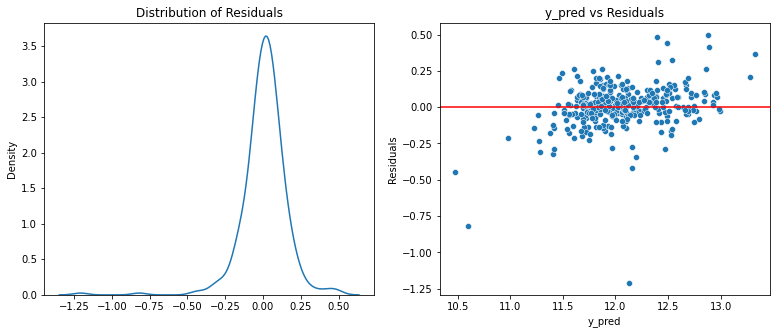

In [66]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

In [87]:
[ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)]

[0.913197648109488, 0.8794559892130601]

### Lasso

In [97]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

model_cv.best_params_

best_lasso_model = Lasso(alpha=model_cv.best_params_["alpha"])
best_lasso_model.fit(X_train, y_train)

y_train_pred = best_lasso_model.predict(X_train)
y_test_pred = best_lasso_model.predict(X_test)

#[ np.sum(np.square(y_train.values.reshape(-1) - y_train_pred)), np.sum(np.square(y_test.values.reshape(-1) - y_test_pred)) ]
metrics = [ [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            [ mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) ]
 ]

df_lasso_metrics = pd.DataFrame(metrics, columns=["Train", "Test"], index=["R2_Score", "MSE", "RMSE"] )
print(df_lasso_metrics)

metrics = [ r2_score(y_train, y_train_pred),  r2_score(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred),
            mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False) 
        ]

ls_metric = pd.Series(metrics, name = 'Lasso Regression')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
           Train    Test
R2_Score 0.91320 0.87946
MSE      0.01309 0.02016
RMSE     0.11443 0.14197


In [99]:
best_lasso_model.alpha

0.001

In [101]:
doubled_lasso_model = Lasso(alpha=model_cv.best_params_["alpha"] * 2)
doubled_lasso_model.fit(X_train, y_train)

Lasso(alpha=0.002)

In [118]:
betas_lasso = pd.DataFrame(index=X_train.columns)
betas_lasso.rows = X_train.columns
betas_lasso['Lasso'] = doubled_lasso_model.coef_
betas_lasso['Lasso_Abs'] = np.abs(betas_lasso)

betas_lasso.sort_values(by="Lasso_Abs", ascending=False)

Lasso  Lasso_Abs
GrLivAreaLog          1.09643    1.09643
BsmtQual_Ex           0.13951    0.13951
1stFlrSFLog           0.13774    0.13774
GarageAreaLog         0.13394    0.13394
Neighborhood_NoRidge  0.12205    0.12205
...                       ...        ...
RoofMatl_ClyTile     -0.00000    0.00000
RoofMatl_CompShg      0.00000    0.00000
RoofMatl_Membran      0.00000    0.00000
RoofMatl_Roll        -0.00000    0.00000
MiscValSqrt          -0.00000    0.00000

[262 rows x 2 columns]

#### Residual Analysis

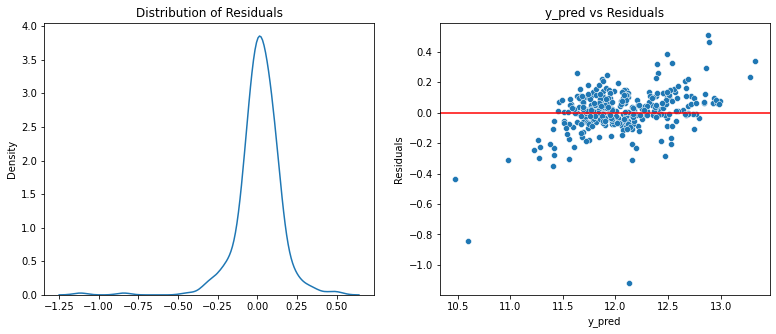

In [68]:
errors = (y_test.values.reshape(-1) - y_test_pred.reshape(-1))
residual_analysis(errors, y_test)

In [69]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)
final_metric

Metric            Linear Regression  Ridge Regression  \
0  R2 Score (Train)                      0.95228           0.93357   
1   R2 Score (Test) -210715629916405039104.00000           0.86652   
2       MSE (Train)                      0.00720           0.01002   
3        MSE (Test)   35232242202696896512.00000           0.02232   
4      RMSE (Train)                      0.08484           0.10010   
5       RMSE (Test)             5935675378.81722           0.14939   

   Lasso Regression  
0           0.91320  
1           0.87946  
2           0.01309  
3           0.02016  
4           0.11443  
5           0.14197

### Top10 features & Coeff

In [122]:
top_10_features = get_top_1o_features(X_train, lr_model, best_ridge_model, best_lasso_model)
top_10_features

LR            LR_coeff                 Ridge Ridge_coeff  \
0  GarageFinish_Fin -228894597221.26550      RoofMatl_ClyTile    -0.38184   
1  GarageFinish_Unf -228894597221.26303          GrLivAreaLog     0.35141   
2  GarageFinish_RFn -228894597221.26260           1stFlrSFLog     0.32656   
3      LotShape_IR3  140758377598.42578              2ndFlrSF     0.20438   
4      LotShape_IR2  140758377598.40042        TotalBsmtSFLog     0.18286   
5      LotShape_IR1  140758377598.37537      MSZoning_C (all)    -0.16571   
6      LotShape_Reg  140758377598.37506             GrLivArea     0.16419   
7    KitchenQual_Fa -129302116722.41554  Neighborhood_MeadowV    -0.15955   
8    KitchenQual_Gd -129302116722.39926      RoofMatl_CompShg     0.15061   
9    KitchenQual_TA -129302116722.39528         GarageAreaLog     0.15000   

                  Lasso Lasso_coeff  
0          GrLivAreaLog     0.84617  
1      RoofMatl_ClyTile    -0.61696  
2           1stFlrSFLog     0.38214  
3      MSZoning_C (all)    -0.18090  
4              2ndFlrSF     0.15702  
5  Neighborhood_Crawfor     0.14485  
6         GarageAreaLog     0.14067  
7  Neighborhood_NoRidge     0.13735  
8           BsmtQual_Ex     0.12466  
9        KitchenQual_Ex     0.12008

#### Question 2

In [120]:
( best_ridge_model.coef_ > 0 ).sum()

137

In [121]:
( best_lasso_model.coef_ > 0 ).sum()

49

#### Question 3

##### Top 5 features of lasso model

In [195]:
top_10_features['Lasso'].iloc[:5].to_list()

['GrLivAreaLog',
 'RoofMatl_ClyTile',
 '1stFlrSFLog',
 'MSZoning_C (all)',
 '2ndFlrSF']

In [222]:
features_to_drop = ['GrLivArea', 'RoofMatl', '1stFlrSF', 'MSZoning', '2ndFlrSF']
df =  house_df.drop(features_to_drop, axis=1)
df.head()

MSSubClass  LotFrontage  LotArea Street LotShape LandContour Utilities  \
0          60     65.00000     8450   Pave      Reg         Lvl    AllPub   
1          20     80.00000     9600   Pave      Reg         Lvl    AllPub   
2          60     68.00000    11250   Pave      IR1         Lvl    AllPub   
3          70     60.00000     9550   Pave      IR1         Lvl    AllPub   
4          60     84.00000    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    Inside       Gtl      CollgCr  ...             0         0           0   
1       FR2       Gtl      Veenker  ...             0         0           0   
2    Inside       Gtl      CollgCr  ...             0         0           0   
3    Corner       Gtl      Crawfor  ...           272         0           0   
4       FR2       Gtl      NoRidge  ...             0         0           0   

  PoolArea  MiscVal  MoSold  YrSold  SaleType SaleCondition SalePrice  
0        0        0       2    2008        WD        Normal    208500  
1        0        0       5    2007        WD        Normal    181500  
2        0        0       9    2008        WD        Normal    223500  
3        0        0       2    2006        WD       Abnorml    140000  
4        0        0      12    2008        WD        Normal    250000  

[5 rows x 70 columns]

In [223]:
non_num_cols = df.dtypes[house_df.dtypes == 'object'].index
num_cols = df.dtypes[(house_df.dtypes == "int64") | (house_df.dtypes == "float64")].index

cat_cols = non_num_cols.tolist() + ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold" ]
cont_cols = []
for col in num_cols:
    if col not in ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold" ]:
        cont_cols.append(col)

#### Preprocessing

In [224]:
dummies_df = pd.get_dummies(df[cat_cols])

df = pd.concat([df, dummies_df], axis=1)
df.drop(cat_cols, axis=1, inplace=True)
df.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0     65.00000     8450       2003          2003   196.00000         706   
1     80.00000     9600       1976          1976     0.00000         978   
2     68.00000    11250       2001          2002   162.00000         486   
3     60.00000     9550       1915          1970     0.00000         216   
4     84.00000    14260       2000          2000   350.00000         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  LowQualFinSF  ...  SaleType_ConLw  \
0           0        150          856             0  ...               0   
1           0        284         1262             0  ...               0   
2           0        434          920             0  ...               0   
3           0        540          756             0  ...               0   
4           0        490         1145             0  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      1   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 232 columns]

In [225]:
num_cols = df.dtypes[(df.dtypes == "int64") | (df.dtypes == "float64")].index
cont_cols = []
for col in num_cols:
    if col not in ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold" ]:
        cont_cols.append(col)

len(cont_cols)

21

In [227]:
log_cols = ["LotFrontage", "LotArea", "TotalBsmtSF", "GarageArea"]

for col in log_cols:
    df[col + "Log"] = np.log(df[col])

log_cols = [ col+'Log' for col in log_cols]

sqrt_cols = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
                "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "MiscVal" ]

for col in sqrt_cols:
    df[col + "Sqrt"] = np.sqrt(df[col])
    df[col + "Sqrt"] = np.sqrt(df[col])

sqrt_cols = [ col+'Sqrt' for col in sqrt_cols]

In [228]:
features = df.columns.drop("SalePrice")
target = "SalePrice"

df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)
print(df_train.shape)
print(df_test.shape)

X_train = df_train[features]
y_train = df_train[[target]]

X_test = df_test[features]
y_test = df_test[[target]]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(765, 245)
(329, 245)
(765, 244) (765, 1)
(329, 244) (329, 1)


In [230]:
new_cont_cols = sqrt_cols + log_cols + cont_cols

scalerX = MinMaxScaler()
#scaler = StandardScaler()

X_train[new_cont_cols[:-1]] = scalerX.fit_transform(X_train[new_cont_cols[:-1]])
X_train[cont_cols[:-1]].describe()

X_test[new_cont_cols[:-1]] = scalerX.transform(X_test[new_cont_cols[:-1]])
X_test[new_cont_cols[:-1]].describe()

y_train = np.log(y_train)
y_test = np.log(y_test)

In [233]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

model_cv.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


{'alpha': 0.001}

In [234]:
dropped_best_lasso_model = Lasso(alpha=model_cv.best_params_["alpha"])
dropped_best_lasso_model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [235]:
betas_droppedLasso = pd.DataFrame(index=X_train.columns)
betas_droppedLasso.rows = X_train.columns
betas_droppedLasso['Lasso'] = dropped_best_lasso_model.coef_.reshape(-1)
betas_droppedLasso['Lasso_Abs'] = np.abs(betas_droppedLasso['Lasso'] )

betas_droppedLasso.sort_values(by="Lasso_Abs", ascending=False)

Lasso  Lasso_Abs
TotalBsmtSFLog        0.78450    0.78450
LotAreaLog            0.30304    0.30304
GarageAreaLog         0.23166    0.23166
Neighborhood_Crawfor  0.22171    0.22171
Neighborhood_NoRidge  0.19784    0.19784
...                       ...        ...
Exterior1st_HdBoard  -0.00000    0.00000
Exterior1st_ImStucc  -0.00000    0.00000
Exterior1st_MetalSd  -0.00000    0.00000
Exterior1st_Stone     0.00000    0.00000
MiscValSqrt          -0.00000    0.00000

[244 rows x 2 columns]

The company wants to know:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.


Also, determine the optimal value of lambda for ridge and lasso regression.

- Sum of residual metrics

# Variable selection techniques

# MSSubclass is non-numeric col